This code implements the Bacon Barnett and Scattergood Fourier-transform approach to computing a general elastic Green's function and its derivative.

In [2]:
using LinearAlgebra, ForwardDiff, Printf, LaTeXStrings, Random, Distributions

In [3]:
import Plots, PyPlot

In [4]:
# Functions to convert Voigt indices to normal indices in 2D and 3D.
# (For convenience of constructing tensors from the literature)

function Voigt3D(ij)
    if ij[1]==ij[2]
        return ij[1]
    elseif (ij[1]==2 && ij[2]==3) | (ij[1]==3 && ij[2]==2)
        return 4;
    elseif (ij[1]==3 && ij[2]==1) | (ij[1]==1 && ij[2]==3)
        return 5;
    elseif (ij[1]==1 && ij[2]==2) | (ij[1]==2 && ij[2]==1)
        return 6;
    else
        error("Invalid 3D index pair")
    end
end

function Voigt3DInv(i)
    if i==1
        return [1 1];
    elseif i==2
        return [2 2];
    elseif i==3
        return [3 3];
    elseif i==4
        return [2 3];
    elseif i==5
        return [1 3];
    elseif i==6
        return [1 2];
    else
        error("Invalid 3D Voigt index")
    end
end

function Voigt2D(ij)
    if ij[1]==ij[2]
        return ij[1]
    elseif (ij[1]==1 && ij[2]==2) | (ij[1]==2 && ij[2]==1)
        return 3;
    else
        error("Invalid 2D index pair")
    end
end

function Voigt2DInv(i)
    if i==1
        return [1 1];
    elseif i==2
        return [2 2];
    elseif i==3
        return [1 2];
    else
        error("Invalid 2D Voigt index")
    end
end

Voigt2DInv (generic function with 1 method)

In [5]:
"""
* `GreenTensor3D(x::vector,C::Tensor,n::Int) -> G::Tensor`
Computes the full 3D Green tensor at the point x for elasticity
tensor ℂ ∈ ℝ³ˣ³ˣ³ˣ³.
"""
function GreenTensor3D(x,ℂ,n)
    # Error handling (NB: this should not be necessary once we define types correctly.)
    if ~( size(x)==(3,) ) && ~( size(x)==(3,1) )
        error("Input is not a 3D column vector");
    elseif ~( size(ℂ)==(3,3,3,3) )
        error("Elasticity tensor incorrect size");
    end
        
    G = zeros(Float64,3,3);
    # basis is a 3x2 matrix of vectors orthogonal to x.
    basis = nullspace(x');
    for m=0:n-1
        zz = zeros(Float64,3,3);
        z = basis*[cos(pi*m/n); sin(pi*m/n)];
        for i=1:3, j=1:3
            for k=1:3, l=1:3
                zz[i,j] += z[k]*ℂ[i,k,j,l]*z[l];
            end
        end
        zzinv = inv(zz)
        G += zzinv;
    end
    G = G/(4*pi*norm(x)*n)
    return G
end

"""
* `GradGreenTensor3D(x::vector,C::Tensor,n::Int) -> DG::Tensor`
Computes the gradient of the 3D Green tensor at the point x for elasticity
tensor ℂ ∈ ℝ³ˣ³ˣ³ˣ³.
"""
function GradGreenTensor3D(x,ℂ,n)
    # Error handling (NB: this should not be necessary once we define types correctly.)
    if ~( size(x)==(3,) ) && ~( size(x)==(3,1) )
        error("Input is not a 3D column vector");
    elseif ~( size(ℂ)==(3,3,3,3) )
        error("Elasticity tensor incorrect size");
    end
    
    # Initialise tensors.
    DG = zeros(Float64,3,3,3);
    T = x/norm(x);
    F = zeros(Float64,3,3);
    
    # Basis is a 3x2 matrix of vectors orthogonal to x.
    basis = nullspace(x'); #<---- Code in more explicit basis vectors for x
    
    
    # Integrate
    for m=0:n-1
        zz = zeros(Float64,3,3);
        zT = zeros(Float64,3,3);
        z = basis*[cos(2*pi*m/n); sin(2*pi*m/n)];
        for i=1:3, j=1:3, r=1:3, s=1:3
            zz[i,j] += z[r]*ℂ[i,r,j,s]*z[s];
            zT[i,j] += z[r]*ℂ[i,r,j,s]*T[s];
        end
        zzinv = inv(zz);
        F = (zz\(zT+zT'))/zz;
        for i=1:3, j=1:3, k=1:3
            DG[i,j,k] += T[k]*zzinv[i,j]-z[k]*F[i,j];
        end
    end
    DG = -DG/(4*pi*norm(x)^2*n)
    
    #DG = real.(DG)
    #contains_dual = any(y -> isa(y, ForwardDiff.Dual), DG)
    #println("Dual elements: ", contains_dual, "\n")
    return DG
end

"""
* `GreenTensor3DIso(x::vector,μ::Float64,λ::Float64) -> G::Tensor`
Returns the 3D Isotropic Green tensor at the point x via exact formula
with Lamé parameters μ and λ.
"""
function GreenTensor3DIso(x,μ,λ)
    # Error handling.
    if ~( size(x)==(3,) ) && ~( size(x)==(3,1) )
        error("Input is not a 3D column vector");
    end
        
    G = ((λ+3*μ)/(λ+2*μ)*I(3)/norm(x)+(λ+μ)/(λ+2*μ)*x*x'/norm(x)^3)/(8*pi*μ);
    
    return G
end

"""
* `GradGreenTensor3DIso(x::vector,μ::Float64,λ::Float64,n::Int) -> DG::Tensor`
Computes the gradient of the 3D Green tensor at the point x for an Isotropic
elasticity tensor with Lamé parameters μ and λ.
"""
function GradGreenTensor3DIso(x,μ,λ)
    # Error handling.
    if ~( size(x)==(3,) ) && ~( size(x)==(3,1) )
        error("Input is not a 3D column vector");
    end
    
    DG = zeros(Float64,3,3,3);
    Id = I(3);
    
    for i=1:3, j=1:3, k=1:3
            DG[i,j,k] = ( (λ+μ)*(Id[i,k]*x[j]+Id[j,k]*x[i]) - (λ+3*μ)*I(3)[i,j]*x[k] ) -
                            3*(λ+μ)*x[i]*x[j]*x[k]/(norm(x)^2);
    end
    DG = DG/(8*pi*μ*(λ+2*μ)*norm(x)^3);
    
    return DG
end



GradGreenTensor3DIso

In [6]:
#############################################
# 2D ANISOTROPIC CODE NOT CURRENTLY WORKING #
#############################################

#"""
#* `GreenTensor2D(x::vector,C::Tensor,n::Int) -> u::vector`
#Computes the full 2D Green tensor at the point x for elasticity
#tensor ℂ ∈ ℝ²ˣ²ˣ²ˣ².
#"""

#function GreenTensor2D(x,ℂ,n)
#    if ~( size(x)==(2,) ) && ~( size(x)==(2,1) )
#        error("Input is not a 2D column vector");
#    elseif ~( size(ℂ)==(2,2,2,2) )
#        error("Elasticity tensor incorrect size");
#    end
#    
#    # We implement the Bacon-Barnett-Scattergood method.
#    # Initialise matrices
#    Q = zeros(Float64,2,2);
#    S = zeros(Float64,2,2);
#    B = zeros(Float64,2,2);
#    G = zeros(Float64,2,2);
#    
#    # Main loop to calculate Q, S, B.
#    for h=0:n-1
#        mvec = [cos(pi*h/n); sin(pi*h/n)];
#        nvec = [-sin(pi*h/n); cos(pi*h/n)];
#        nn = zeros(Float64,2,2);
#        nm = zeros(Float64,2,2);
#        mm = zeros(Float64,2,2);
#        for i=1:2, j=1:2
#            for k=1:2, l=1:2
#                nn[i,j] += nvec[k]*ℂ[k,i,j,l]*nvec[l];
#                nm[i,j] += nvec[k]*ℂ[k,i,j,l]*mvec[l];
#                mm[i,j] += mvec[k]*ℂ[k,i,j,l]*mvec[l];
#            end
#        end
#        Q += 2*inv(nn)/n;
#        S += 2*inv(nn)*nm/n;
#        B += 2*(mm-nm'*inv(nn)*nm)/(4*pi*n);
#    end
#    
#    return Q,S,B
#    ## xperp is orthogonal to x.
#    #xperp = nullspace(x');
#    ## zperp contributes to the 'O(1)' part of the 2D Green function.
#    #zzperp = zeros(Float64,2,2);
#    #for i=1:2, j=1:2
#    #    for k=1:2, l=1:2
#    #        zzperp[i,j] += xperp[k]*C[k,i,j,l]*xperp[l];
#    #    end
#    #end
#    ## Now evaluate the log part by integrating.
#    #for m=0:n-1
#    #    zz = zeros(Float64,2,2);
#    #    z = cos(2*pi*m/n)*x/norm(x)+sin(2*pi*m/n)*xperp;
#    #    for i=1:2, j=1:2
#    #        for k=1:2, l=1:2
#    #            zz[i,j] += z[k]*C[k,i,j,l]*z[l];
#    #        end
#    #    end
#    #    G += inv(zz)
#    #end
#    #G = -log(norm(x))*G/n-zzperp
#    #G = G/(2*pi)
#    #return G
#end

"""
* `GreenTensor2DIso(x::vector,μ::Float64,λ::Float64) -> G::Tensor`
Returns the 2D Isotropic Green tensor at the point x via exact formula
with Lamé parameters μ and λ.
"""
function GreenTensor2DIso(x,μ,λ)
    # Error handling.
    if ~( size(x)==(2,) ) && ~( size(x)==(2,1) )
        error("Input is not a 3D column vector");
    end
        
    G = ((λ+μ)*x*x'/norm(x)^2-(λ+3*μ)*I(2)*log(norm(x)))/(4*pi*μ*(λ+2*μ));
    
    return G
end

GreenTensor2DIso

In [7]:
# Testing: CVoigtnD are Voigt elasticities in nD, and we use isotropy for testing purposes.
# Note very few quadrature points are needed in the isotropic case, but more will be needed with increasing anisotropy.
# Choose Lamé parameters.
λ = 1.0; μ = 1.0;
# 3D Voigt elasticities.
CVoigt3D = [λ+2*μ λ     λ     0   0   0;
            λ     λ+2*μ λ     0   0   0;
            λ     λ     λ+2*μ 0   0   0;
            0     0     0     μ   0   0;
            0     0     0     0   μ   0;
            0     0     0     0   0   μ];
# 2D Voigt elasticities.
CVoigt2D = [λ+2*μ λ     0;
            λ     λ+2*μ 0;
            0     0     μ];

# Convert to full elasticity tensors.
C3D = zeros(3,3,3,3);
for i=1:3, j=1:3, k=1:3, l=1:3
    C3D[i,j,k,l] = CVoigt3D[Voigt3D([i j]),Voigt3D([k l])];
end

C2D = zeros(2,2,2,2);
for i=1:2, j=1:2, k=1:2, l=1:2
    C2D[i,j,k,l] = CVoigt2D[Voigt2D([i j]),Voigt2D([k l])];
end

# Now test GreenFunction3D by returning residual in Frobenius norm.
x = [-4; 4; 5.5];
print(join(["Residual of Green tensor = " string(norm(GreenTensor3D(x,C3D,2)-GreenTensor3DIso(x,μ,λ))) "\n"]));
println;
print(join(["Residual of Gradient of Green tensor = " string(norm(GradGreenTensor3D(x,C3D,30)-GradGreenTensor3DIso(x,μ,λ))) "\n"]))

Residual of Green tensor = 2.0108954639236395e-18
Residual of Gradient of Green tensor = 5.077678164905298e-19


In [8]:
# With this method, will compare finding the displacement field via Greens's tensors and the Fourier method:
# Choose Lamé parameters.
μ = 145e9;
poissonRatio = 0.28;
λ = (2*μ*poissonRatio)/(1 - 2*poissonRatio);
# 3D Voigt elasticities.
CVoigt3D = [λ+2*μ λ     λ     0   0   0;
            λ     λ+2*μ λ     0   0   0;
            λ     λ     λ+2*μ 0   0   0;
            0     0     0     μ   0   0;
            0     0     0     0   μ   0;
            0     0     0     0   0   μ];
# 2D Voigt elasticities.
CVoigt2D = [λ+2*μ λ     0;
            λ     λ+2*μ 0;
            0     0     μ];

# Convert to full elasticity tensors.
C3D = zeros(3,3,3,3);
for i=1:3, j=1:3, k=1:3, l=1:3
    C3D[i,j,k,l] = CVoigt3D[Voigt3D([i j]),Voigt3D([k l])];
end

C2D = zeros(2,2,2,2);
for i=1:2, j=1:2, k=1:2, l=1:2
    C2D[i,j,k,l] = CVoigt2D[Voigt2D([i j]),Voigt2D([k l])];
end

# Lattice spacing:
a = 3.18e-10;
#Non-dimensionalising:
a = a/a;
# Dislocation radius:
R = 10*a;

# Prismatic dislocation:
burgers = 1/2 * [1.0; 1.0; 1.0] * a;
nu = [1.0, 1.0, 0.0];
x = [1*a; 1*a; 20*a];

delta_x = 1e-6;

#fourier_strain, fourier_stress = zeros(Float64,3,3);
green_strain, green_stress = zeros(Float64,3,3);

"""
# Far field limit, ignoring kronecker delta:
function u_disp_fourier(x, μ, λ, burgers, nu, R)
    u_fourier = zeros(Float64,3);
    beta_c = burgers/(2.0 * pi)^(1/2) * ((4.0 * μ + λ) - (λ/μ +1)) * R^2;
    u_fourier = - 2.0 * pi^2 * beta_c * dot(nu, x)/norm(x)^3
    return u_fourier
end

u_fourier = zeros(Float64,3);
u_fourier = u_disp_fourier(x, μ, λ, burgers, nu, R);

print(join(["Fourier method: " string(u_fourier) "\n"]));

fourier_strain = ForwardDiff.jacobian(y -> u_disp_fourier(y, μ, λ, burgers, nu, R), x);
print("Strain via Fourier method: \n")
print(fourier_strain[1,:], "\n")
print(fourier_strain[2,:], "\n")
print(fourier_strain[3,:], "\n")
print("\n")"""


function calculate_jacobian_Iso(u_func, x, ℂ, burgers, nu, R, delta_x)
    n = length(x);
    m = length(u_func(x, ℂ, burgers, nu, R));
    
    jacobian_matrix = zeros(Float64, m, n);
    
    for i in 1:n
        x_plus_dx = copy(x);
        x_plus_dx[i] += delta_x;
        
        x_minus_dx = copy(x);
        x_minus_dx[i] -= delta_x;
        
        jacobian_matrix[:, i] = (u_func(x_plus_dx, ℂ, burgers, nu, R) - u_func(x_minus_dx, ℂ, burgers, nu, R)) / (2.0 * delta_x);
    end
    
    return jacobian_matrix
end

function calculate_jacobian(u_func, x, ℂ, burgers, nu, R, delta_x, quad)
    n = length(x);
    m = length(u_func(x, ℂ, burgers, nu, R, quad));
    
    jacobian_matrix = zeros(Float64, m, n);
    
    for i in 1:n
        x_plus_dx = copy(x);
        x_plus_dx[i] += delta_x;
        
        x_minus_dx = copy(x);
        x_minus_dx[i] -= delta_x;
        
        jacobian_matrix[:, i] = (u_func(x_plus_dx, ℂ, burgers, nu, R, quad) - u_func(x_minus_dx, ℂ, burgers, nu, R, quad)) / (2.0 * delta_x);
    end
    
    return jacobian_matrix
end

function hookes_law(strain, ℂ)
    stress = zeros(Float64, 3, 3);
    for i=1:3, j=1:3, k=1:3, l=1:3
       stress[i, j] += ℂ[i, j, k, l] * strain[k, l];
    end
    return stress
end

#-------------------------------------------------------------------------------------------------
# Green's tensor formalism to leading order:

# Displacement using the explicit isotropic expression for the gradient of the Green's tensor:
function u_disp_green_Iso(x, ℂ, burgers, nu, R)
    DG = GradGreenTensor3DIso(x,μ,λ);
    u_green = zeros(Float64,3);
    for α=1:3, β=1:3, p=1:3, q=1:3, r=1:3
        u_green[α] += ℂ[β, p, q, r] * burgers[q] * nu[r] * DG[β, α, p] * pi * R^2;
    end
    return u_green
end

# Displacement for a general Green's tensor (need not be isotropic):
function u_disp_green(x, ℂ, burgers, nu, R, n)
    DG = GradGreenTensor3D(x, ℂ, n);
    u_green = zeros(Float64,3);
    for α=1:3, β=1:3, p=1:3, q=1:3, r=1:3
        u_green[α] += ℂ[β, p, q, r] * burgers[q] * nu[r] * DG[β, α, p] * pi * R^2;
    end
    return u_green
end

#-----------------------------------------------------------------------------------------------
# 2nd order expression:  (TO BE IMPLEMENTED AFTER PROJECT)
"""
function u_disp_green_2(x, ℂ, burgers, nu, R)
    DG = GradGreenTensor3D(x, ℂ, 30);
    #DG_2D = DG[1:2, 1:2, 1];
    #x_2D = x[1:2];
    hess_DG=ForwardDiff.hessian(DG, x);
    u_green_2 = zeros(Float64,3);
    for α=1:3, β=1:3, p=1:3, q=1:3, r=1:3
        u_green_2[α] += ℂ[β, p, q, r] * burgers[q] * nu[r] * DG[β, α, p] * pi * R^4/16;
    end
    return u_green_2
end"""
#------------------------------------------------------------------

#function u_disp_green_wrapper(x)
#    return u_disp_green(x, C3D, grad_green, burgers, nu, R)
#end

#grad_green = GradGreenTensor3D(x, C3D, 30);
#print("DG :", grad_green, "\n")
u_green = zeros(Float64,3);
#u_green = u_disp_green(x, C3D, grad_green, burgers, nu, R);
u_green = u_disp_green(x, C3D, burgers, nu, R, 30);

print("Green's method: ", string(u_green), "\n");

#u_green_2 = u_disp_green_2(x, C3D, burgers, nu, R);

#print("2nd order": , string(u_green_2), "\n");

#green_strain = ForwardDiff.jacobian(y -> u_disp_green(y, C3D, grad_green, burgers, nu, R), x);
#green_strain = ForwardDiff.jacobian(u_disp_green_wrapper, x);
green_strain = calculate_jacobian(u_disp_green, x, C3D, burgers, nu, R, delta_x, 30);

print("Strain via Green method: \n")
@printf("[%e, %e, %e] \n", green_strain[1,1], green_strain[1,2], green_strain[1,3]);
@printf("[%e, %e, %e] \n", green_strain[2,1], green_strain[2,2], green_strain[2,3]);
@printf("[%e, %e, %e] \n", green_strain[3,1], green_strain[3,2], green_strain[3,3]);
print("\n")

green_stress = hookes_law(green_strain, C3D);

print("Stress via Green method: \n")
@printf("[%e, %e, %e] \n", green_stress[1,1], green_stress[1,2], green_stress[1,3]);
@printf("[%e, %e, %e] \n", green_stress[2,1], green_stress[2,2], green_stress[2,3]);
@printf("[%e, %e, %e] \n", green_stress[3,1], green_stress[3,2], green_stress[3,3]);
print("\n")

function middle_eigenvalue(matrix)
    eigenvalues = eigvals(matrix)
    sorted_eigenvalues = sort(eigenvalues)
    middle_index = div(length(sorted_eigenvalues), 2) + 1
    middle_eigenvalue = sorted_eigenvalues[middle_index]
    return middle_eigenvalue
end

principalStresses = eigvals(green_stress);
maxPrincipal = eigmax(green_stress);
minPrincipal = eigmin(green_stress);
midPrincipal = middle_eigenvalue(green_stress);
print("Principal stresses: \n");
print(principalStresses, "\n");
print("Maximum principal: \n");
print(maxPrincipal, "\n");
print("Minimum principal: \n");
print(minPrincipal, "\n");
print("Middle principal: \n");
print(midPrincipal, "\n");


Green's method: [-0.010778821552547922, -0.010778821552547925, 0.010934421338739564]
Strain via Green method: 
[-4.643298e-04, -1.058438e-03, 1.154021e-03] 
[-1.058438e-03, -4.643298e-04, 1.154021e-03] 
[-4.378131e-03, -4.378131e-03, -6.556291e-04] 

Stress via Green method: 
[-4.270289e+08, -3.069470e+08, -4.674959e+08] 
[-3.069470e+08, -4.270289e+08, -4.674959e+08] 
[-4.674959e+08, -4.674959e+08, -4.825057e+08] 

Principal stresses: 
[-1.281229888705586e9, -1.2008188449752253e8, 6.474818153153023e7]
Maximum principal: 
6.474818153153023e7
Minimum principal: 
-1.281229888705586e9
Middle principal: 
-1.2008188449752253e8


In [8]:
# Determining optimal quadrature points for error, with an error convergence plot:
# Predetermined position - a controlled variable for this plot:
r = 20*a;
theta = 0;
phi = pi/4;
position = [r*sin(theta)*cos(phi); r*sin(theta)*sin(phi); r*cos(theta)]; 
# Lattice spacing:
a = 3.18e-10;
#Non-dimensionalising:
a = a/a;
# Dislocation radius:
R = 10*a;
# Prismatic dislocation:
burgers = 1/2 * [1.0; 1.0; 1.0] * a;
nu = [1.0, 1.0, 0.0];
# Jacobian finite diff step:
delta_x = 1e-6;

errors = [];
nArr = 1:1:15;
stressErrors = Array{Float64,1}(undef, size(nArr)[1]);
for i=1:size(nArr)[1]
    strain_iso = calculate_jacobian_Iso(u_disp_green_Iso, position, C3D, burgers, nu, R, delta_x);
    stress_iso = hookes_law(strain_iso, C3D);
    maxP_iso = eigmax(stress_iso);
    newStrain = calculate_jacobian(u_disp_green, position, C3D, burgers, nu, R, delta_x, nArr[i]);
    newStress = hookes_law(newStrain, C3D);
    maxP = eigmax(newStress);
    error = abs((maxP_iso - maxP)/maxP_iso) ; 
    stressErrors[i] = error;
end

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


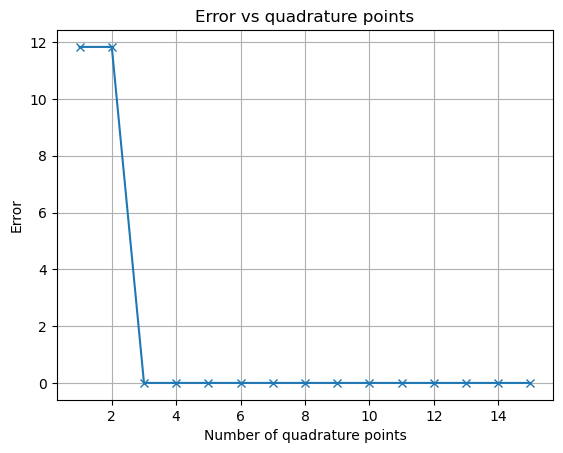

In [84]:
# Quadrature error convergence plot:
#--------------------------------------------Initialising latex formatting:--------------------------------
PyPlot.rcdefaults()
const rc = PyPlot.matplotlib.rcParams
rc["text.usetex"] = true
rc["text.latex.preamble"] = "\\usepackage{mathtools,amssymb}"
rc["font.family"] = "serif"
Plots.default(formatter = :latex)
#------------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------------
PyPlot.plot(nArr, stressErrors, "-x");
PyPlot.xlabel("Number of quadrature points");
PyPlot.ylabel("Error");
PyPlot.title("Error vs quadrature points");
PyPlot.grid();
PyPlot.savefig("ErrorConvergence.png", dpi=300);
PyPlot.show()

#PyPlot.plot(nArr, stressErrors);
#PyPlot.xlabel("Number of quadrature points");
#PyPlot.ylabel("Error");
#PyPlot.title("Error vs quadrature points");
#PyPlot.xscale("symlog");
#PyPlot.yscale("symlog")
#PyPlot.grid();
#PyPlot.savefig("ErrorConvergence-log.png", dpi=300);
#PyPlot.show()


In [233]:
#Stress vs radial distance - Max Principals:
#------------------------------------------------------Setting parameters: ---------------------------------------
# Lattice spacing:
a = 3.18e-10;
#Non-dimensionalising:
a = a/a;
# Dislocation radius:
R = 10*a;
# Prismatic dislocation:
burgers = 1/2 * [1.0; 1.0; 1.0] * a;
nu_dir = [1.0, 1.0, 0.0];
# Unit normal vector:
nu = nu_dir / norm(nu_dir);
# Jacobian finite diff step:
delta_x = 1e-6;
#-----------------------------------------------------------------------------------------------------------------

#-----------------------------------------Plotting Arrays: -------------------------------------------------------
azimuthAngles1 = [-7*pi/8, -3*pi/4, -5*pi/8, -pi/2, -3*pi/8, -pi/4, -pi/8, 0];
azimuthAngles2 = [pi/8, pi/4, 3*pi/8, pi/2, 5*pi/8, 3*pi/4, 7*pi/8, pi];
fullAzimuthArr = vcat(azimuthAngles1, azimuthAngles2);
polarAngle = pi/2;
radii = range(11*a, 120*a, length=79);
#----------------------------------------------------------------------------------------------------------------

maxPs1 = Array{Float64,2}(undef, size(radii)[1], size(azimuthAngles1)[1]);
maxPs2 = Array{Float64,2}(undef, size(radii)[1], size(azimuthAngles2)[1]);
j = 1;
for azimuthAngle in azimuthAngles1 
    i = 1;
    for r in radii
       newPos = [r*sin(polarAngle)*cos(azimuthAngle); r*sin(polarAngle)*sin(azimuthAngle); r*cos(polarAngle)]; 
       newStrain = calculate_jacobian(u_disp_green, newPos, C3D, burgers, nu, R, delta_x, 30);
       newStress = hookes_law(newStrain, C3D);
       newMaxP = eigmax(newStress);
       maxPs1[i, j] = newMaxP; 
       i = i + 1;
    end
    j = j + 1;
end
j = 1;
for azimuthAngle in azimuthAngles2
    i = 1;
    for r in radii
       newPos = [r*sin(polarAngle)*cos(azimuthAngle); r*sin(polarAngle)*sin(azimuthAngle); r*cos(polarAngle)]; 
       newStrain = calculate_jacobian(u_disp_green, newPos, C3D, burgers, nu, R, delta_x, 30);
       newStress = hookes_law(newStrain, C3D);
       newMaxP = eigmax(newStress);
       maxPs2[i, j] = newMaxP; 
       i = i + 1;
    end
    j = j + 1;
end

folder = "n=["*string(nu_dir[1])*";"*string(nu_dir[2])*";"*string(nu_dir[3])*"]"
if isdir(folder)
    nothing
else
    mkdir(folder);
end

In [234]:
# Creating labels arrays:
phiLabels1 = [];
for angle in azimuthAngles1
    # Check if the number is 0 or not:
    if abs(angle) > 1e-9
        # If it is not 0, check if the denominator is 1, if it isn't then print the denominator:
        if abs(denominator(Rational(angle/pi)) - 1) < 1e-9
            # Finally check if the numerator is 1, -1 or neither, and create the appropriate labels:
            if abs(numerator(Rational(angle/pi)) - 1) < 1e-9
                label = L"\pi$";
            elseif abs(numerator(Rational(angle/pi)) + 1) < 1e-9
                label = "-"*L"\pi$";
            else
                label = string(numerator(Rational(angle/pi)))*L"\pi$/";
            end
        else
            # Finally check if the numerator is 1, -1 or neither, and create the appropriate labels:
            if abs(numerator(Rational(angle/pi)) - 1) < 1e-9
                label = L"\pi$/"*string(denominator(Rational(angle/pi)));
            elseif abs(numerator(Rational(angle/pi)) + 1) < 1e-9
                label = "-"*L"\pi$/"*string(denominator(Rational(angle/pi)));
            else
                label = string(numerator(Rational(angle/pi)))*L"\pi$/"*string(denominator(Rational(angle/pi)));
            end
        end
    else
        label = L"0$";
    end
    phiLabels1 = vcat(phiLabels1, label);
end
phiLabels2 = [];
for angle in azimuthAngles2
    # Check if the number is 0 or not:
    if abs(angle) > 1e-9
        # If it is not 0, check if the denominator is 1, if it isn't then print the denominator:
        if abs(denominator(Rational(angle/pi)) - 1) < 1e-9
            # Finally check if the numerator is 1, -1 or neither, and create the appropriate labels:
            if abs(numerator(Rational(angle/pi)) - 1) < 1e-9
                label = L"\pi$";
            elseif abs(numerator(Rational(angle/pi)) + 1) < 1e-9
                label = "-"*L"\pi$";
            else
                label = string(numerator(Rational(angle/pi)))*L"\pi$/";
            end
        else
            # Finally check if the numerator is 1, -1 or neither, and create the appropriate labels:
            if abs(numerator(Rational(angle/pi)) - 1) < 1e-9
                label = L"\pi$/"*string(denominator(Rational(angle/pi)));
            elseif abs(numerator(Rational(angle/pi)) + 1) < 1e-9
                label = "-"*L"\pi$/"*string(denominator(Rational(angle/pi)));
            else
                label = string(numerator(Rational(angle/pi)))*L"\pi$/"*string(denominator(Rational(angle/pi)));
            end
        end
    else
        label = L"0$";
    end
    phiLabels2 = vcat(phiLabels2, label);
end
# Check if the number is 0 or not:
if abs(polarAngle) > 1e-9
    # If it is not 0, check if the denominator is 1, if it isn't then print the denominator:
    if abs(denominator(Rational(polarAngle/pi)) - 1) < 1e-9
        # Finally check if the numerator is 1, -1 or neither, and create the appropriate labels:
        if abs(numerator(Rational(polarAngle/pi)) - 1) < 1e-9
            polarLabel = L"\pi$";
        elseif abs(numerator(Rational(polarAngle/pi)) + 1) < 1e-9
            polarLabel = "-"*L"\pi$";
        else
            polarLabel = string(numerator(Rational(polarAngle/pi)))*L"\pi$/";
        end
    else
        # Finally check if the numerator is 1, -1 or neither, and create the appropriate labels:
        if abs(numerator(Rational(polarAngle/pi)) - 1) < 1e-9
            polarLabel = L"\pi$/"*string(denominator(Rational(polarAngle/pi)));
        elseif abs(numerator(Rational(polarAngle/pi)) + 1) < 1e-9
            polarLabel = "-"*L"\pi$/"*string(denominator(Rational(polarAngle/pi)));
        else
            polarLabel = string(numerator(Rational(polarAngle/pi)))*L"\pi$/"*string(denominator(Rational(polarAngle/pi)));
        end
    end
else 
    polarLabel = L"0$";
end

"\\pi\$/2"

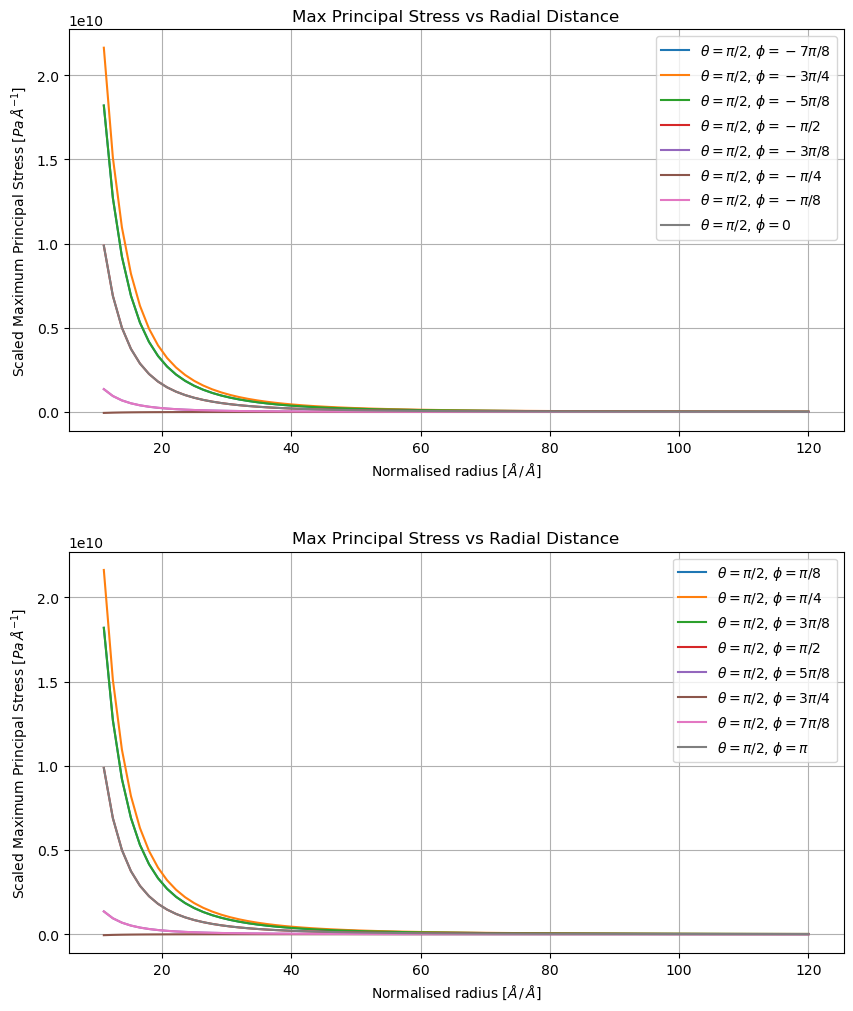

In [235]:
#Max stress vs radius plot:
fig = PyPlot.figure("Stress vs distance",figsize=(10,12)) # Create a new blank figure
PyPlot.subplot(211);
for j = 1:size(azimuthAngles1)[1]
    labelString = L"$\theta = "*polarLabel*L", $\phi = "*phiLabels1[j];
    PyPlot.plot(radii, maxPs1[:, j], label=labelString);
end

PyPlot.title("Max Principal Stress vs Radial Distance");
PyPlot.xlabel(L"Normalised radius [$\AA \, / \, \AA$]");
PyPlot.ylabel(L"Scaled Maximum Principal Stress [$Pa \, \AA^{-1}$]");
PyPlot.grid();
PyPlot.legend();

PyPlot.subplot(212);
for j = 1:size(azimuthAngles2)[1]
    labelString = L"$\theta = "*polarLabel*L", $\phi = "*phiLabels2[j];
    PyPlot.plot(radii, maxPs2[:, j], label=labelString);
end
PyPlot.title("Max Principal Stress vs Radial Distance");
PyPlot.xlabel(L"Normalised radius [$\AA \, / \, \AA$]");
PyPlot.ylabel(L"Scaled Maximum Principal Stress [$Pa \, \AA^{-1}$]");
PyPlot.grid();
PyPlot.legend();

PyPlot.subplots_adjust(hspace=0.3);

fig.canvas.draw() # Update the figure
filename = folder*"/"*"stressVdistance1.png";
PyPlot.savefig(filename, dpi=300);

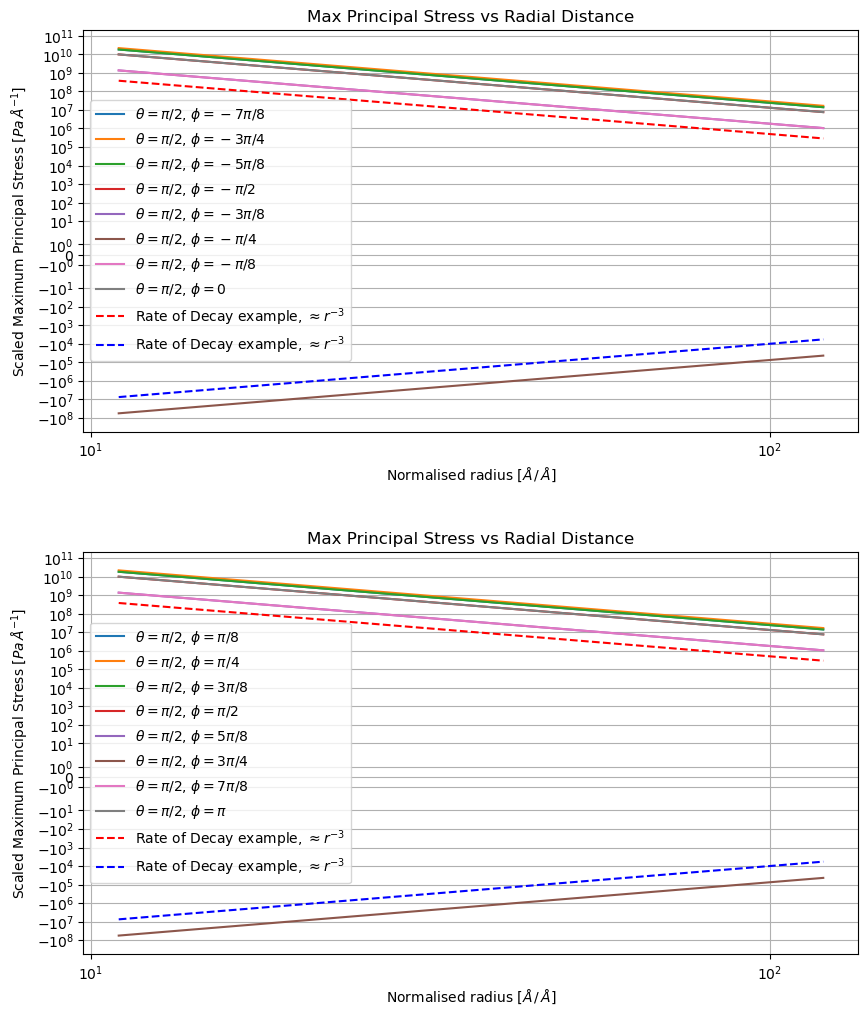

In [236]:
# Log-Log Plot to show rate of decay:
C = 50.0e10;
D = -10.0e9;
decayExamplePlus = [];
decayExampleMinus = [];
decayExamplePlus = [C*r^(-3) for r in radii]
decayExampleMinus = [D*r^(-3) for r in radii]

fig = PyPlot.figure("Stress vs distance",figsize=(10,12)) # Create a new blank figure
PyPlot.subplot(211);
for j = 1:size(azimuthAngles1)[1]
    labelString = L"$\theta = "*polarLabel*L", $\phi = "*phiLabels1[j];
    PyPlot.plot(radii, maxPs1[:, j], label=labelString);
end
PyPlot.plot(radii, decayExamplePlus, "--r", label=L"Rate of Decay example, $\approx r^{-3}$");
PyPlot.plot(radii, decayExampleMinus, "--b", label=L"Rate of Decay example, $\approx r^{-3}$");
PyPlot.title("Max Principal Stress vs Radial Distance");
PyPlot.xlabel(L"Normalised radius [$\AA \, / \, \AA$]");
PyPlot.ylabel(L"Scaled Maximum Principal Stress [$Pa \, \AA^{-1}$]");
PyPlot.yscale("symlog");
PyPlot.xscale("symlog");
PyPlot.grid();
PyPlot.legend();

PyPlot.subplot(212);
for j = 1:size(azimuthAngles2)[1]
    labelString = L"$\theta = "*polarLabel*L", $\phi = "*phiLabels2[j];
    PyPlot.plot(radii, maxPs2[:, j], label=labelString);
end
PyPlot.plot(radii, decayExamplePlus, "--r", label=L"Rate of Decay example, $\approx r^{-3}$");
PyPlot.plot(radii, decayExampleMinus, "--b", label=L"Rate of Decay example, $\approx r^{-3}$");
PyPlot.title("Max Principal Stress vs Radial Distance");
PyPlot.xlabel(L"Normalised radius [$\AA \, / \, \AA$]");
PyPlot.ylabel(L"Scaled Maximum Principal Stress [$Pa \, \AA^{-1}$]");
PyPlot.yscale("symlog");
PyPlot.xscale("symlog");
PyPlot.grid();
PyPlot.legend();

PyPlot.subplots_adjust(hspace=0.3);
fig.canvas.draw() # Update the figure
filename = folder*"/"*"stressVdistance1-log.png";
PyPlot.savefig(filename, dpi=300);

In [237]:
#Stress vs radial distance - Min Principals:
minPs1 = Array{Float64,2}(undef, size(radii)[1], size(azimuthAngles1)[1]);
minPs2 = Array{Float64,2}(undef, size(radii)[1], size(azimuthAngles2)[1]);
j = 1;
for azimuthAngle in azimuthAngles1 
    i = 1;
    for r in radii
       newPos = [r*sin(polarAngle)*cos(azimuthAngle); r*sin(polarAngle)*sin(azimuthAngle); r*cos(polarAngle)]; 
       newStrain = calculate_jacobian(u_disp_green, newPos, C3D, burgers, nu, R, delta_x, 30);
       newStress = hookes_law(newStrain, C3D);
       newMinP = eigmin(newStress);
       minPs1[i, j] = newMinP; 
       i = i + 1;
    end
    j = j + 1;
end
j = 1;
for azimuthAngle in azimuthAngles2
    i = 1;
    for r in radii
       newPos = [r*sin(polarAngle)*cos(azimuthAngle); r*sin(polarAngle)*sin(azimuthAngle); r*cos(polarAngle)]; 
       newStrain = calculate_jacobian(u_disp_green, newPos, C3D, burgers, nu, R, delta_x, 30);
       newStress = hookes_law(newStrain, C3D);
       newMinP = eigmin(newStress);
       minPs2[i, j] = newMinP; 
       i = i + 1;
    end
    j = j + 1;
end

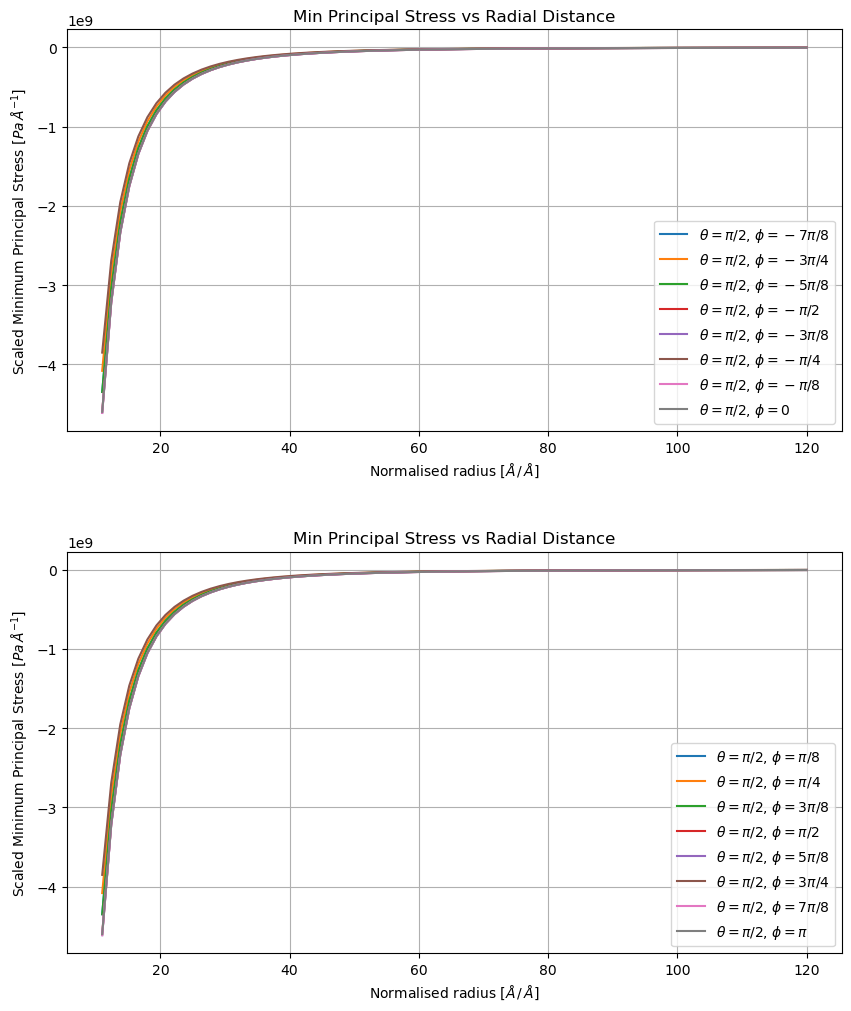

In [238]:
#Min stress vs radius plot:
fig = PyPlot.figure("Stress vs distance",figsize=(10,12)) # Create a new blank figure
PyPlot.subplot(211);
for j = 1:size(azimuthAngles1)[1]
    labelString = L"$\theta = "*polarLabel*L", $\phi = "*phiLabels1[j];
    PyPlot.plot(radii, minPs1[:, j], label=labelString);
end
PyPlot.title("Min Principal Stress vs Radial Distance");
PyPlot.xlabel(L"Normalised radius [$\AA \, / \, \AA$]");
PyPlot.ylabel(L"Scaled Minimum Principal Stress [$Pa \, \AA^{-1}$]");
PyPlot.grid();
PyPlot.legend();

PyPlot.subplot(212);
for j = 1:size(azimuthAngles2)[1]
    labelString = L"$\theta = "*polarLabel*L", $\phi = "*phiLabels2[j];
    PyPlot.plot(radii, minPs2[:, j], label=labelString);
end
PyPlot.title("Min Principal Stress vs Radial Distance");
PyPlot.xlabel(L"Normalised radius [$\AA \, / \, \AA$]");
PyPlot.ylabel(L"Scaled Minimum Principal Stress [$Pa \, \AA^{-1}$]");
PyPlot.grid();
PyPlot.legend();

PyPlot.subplots_adjust(hspace=0.3);
fig.canvas.draw() # Update the figure
filename = folder*"/"*"stressVdistance2.png";
PyPlot.savefig(filename, dpi=300);

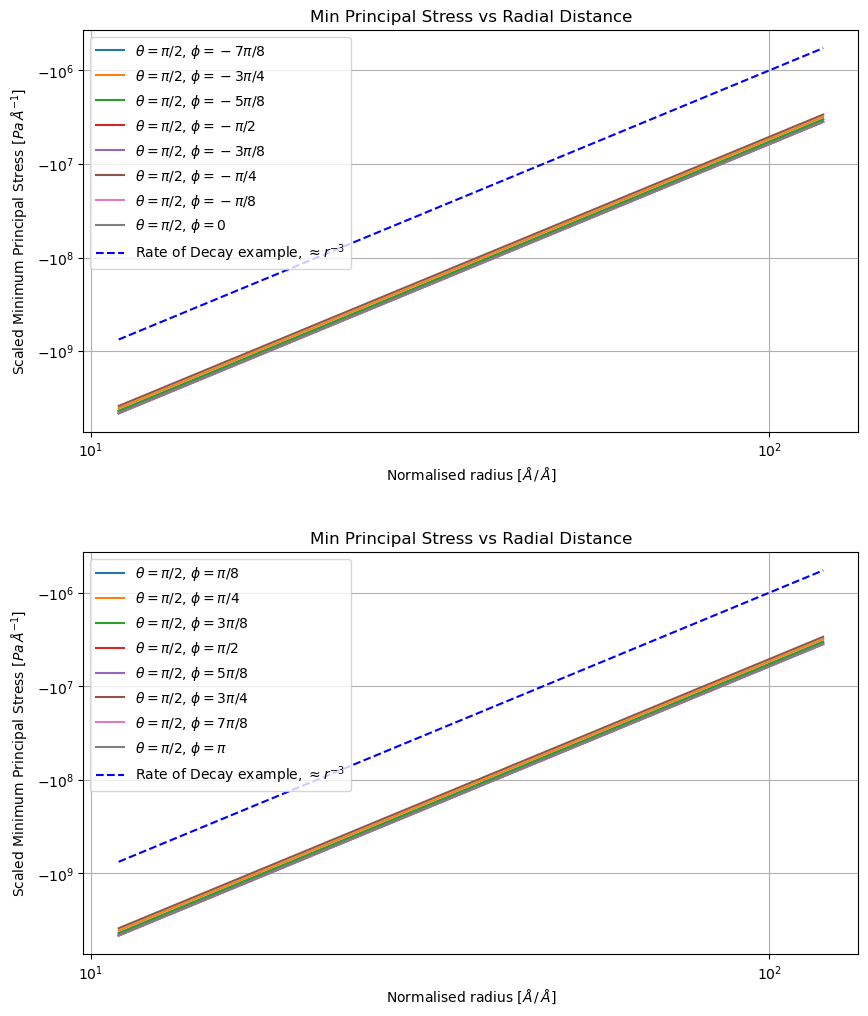

In [239]:
# Log-Log Plot to show rate of decay:
C = 50.0e10;
D = -10.0e11;
decayExamplePlus = [];
decayExampleMinus = [];
decayExamplePlus = [C*r^(-3) for r in radii]
decayExampleMinus = [D*r^(-3) for r in radii]
fig = PyPlot.figure("Stress vs distance",figsize=(10,12)) # Create a new blank figure
PyPlot.subplot(211);
for j = 1:size(azimuthAngles1)[1]
    labelString = L"$\theta = "*polarLabel*L", $\phi = "*phiLabels1[j];
    PyPlot.plot(radii, minPs1[:, j], label=labelString);
end
#PyPlot.plot(radii, decayExamplePlus, "--r", label=L"Rate of Decay example, $\approx r^{-3}$");
PyPlot.plot(radii, decayExampleMinus, "--b", label=L"Rate of Decay example, $\approx r^{-3}$");
PyPlot.title("Min Principal Stress vs Radial Distance");
PyPlot.xlabel(L"Normalised radius [$\AA \, / \, \AA$]");
PyPlot.ylabel(L"Scaled Minimum Principal Stress [$Pa \, \AA^{-1}$]");
PyPlot.yscale("symlog");
PyPlot.xscale("symlog");
PyPlot.grid();
PyPlot.legend();

PyPlot.subplot(212);
for j = 1:size(azimuthAngles2)[1]
    labelString = L"$\theta = "*polarLabel*L", $\phi = "*phiLabels2[j];
    PyPlot.plot(radii, minPs2[:, j], label=labelString);
end
#PyPlot.plot(radii, decayExamplePlus, "--r", label=L"Rate of Decay example, $\approx r^{-3}$");
PyPlot.plot(radii, decayExampleMinus, "--b", label=L"Rate of Decay example, $\approx r^{-3}$");
PyPlot.title("Min Principal Stress vs Radial Distance");
PyPlot.xlabel(L"Normalised radius [$\AA \, / \, \AA$]");
PyPlot.ylabel(L"Scaled Minimum Principal Stress [$Pa \, \AA^{-1}$]");
PyPlot.yscale("symlog");
PyPlot.xscale("symlog");
PyPlot.grid();
PyPlot.legend();

PyPlot.subplots_adjust(hspace=0.3);
fig.canvas.draw() # Update the figure
filename = folder*"/"*"stressVdistance2-log.png";
PyPlot.savefig(filename, dpi=300);

In [240]:
#Stress vs radial distance - Mid Principals:
midPs1 = Array{Float64,2}(undef, size(radii)[1], size(azimuthAngles1)[1]);
midPs2 = Array{Float64,2}(undef, size(radii)[1], size(azimuthAngles2)[1]);
j = 1;
for azimuthAngle in azimuthAngles1 
    i = 1;
    for r in radii
       newPos = [r*sin(polarAngle)*cos(azimuthAngle); r*sin(polarAngle)*sin(azimuthAngle); r*cos(polarAngle)]; 
       newStrain = calculate_jacobian(u_disp_green, newPos, C3D, burgers, nu, R, delta_x, 30);
       newStress = hookes_law(newStrain, C3D);
       newMidP = middle_eigenvalue(newStress);
       midPs1[i, j] = newMidP; 
       i = i + 1;
    end
    j = j + 1;
end
j = 1;
for azimuthAngle in azimuthAngles2
    i = 1;
    for r in radii
       newPos = [r*sin(polarAngle)*cos(azimuthAngle); r*sin(polarAngle)*sin(azimuthAngle); r*cos(polarAngle)]; 
       newStrain = calculate_jacobian(u_disp_green, newPos, C3D, burgers, nu, R, delta_x, 30);
       newStress = hookes_law(newStrain, C3D);
       newMidP = middle_eigenvalue(newStress);
       midPs2[i, j] = newMidP; 
       i = i + 1;
    end
    j = j + 1;
end

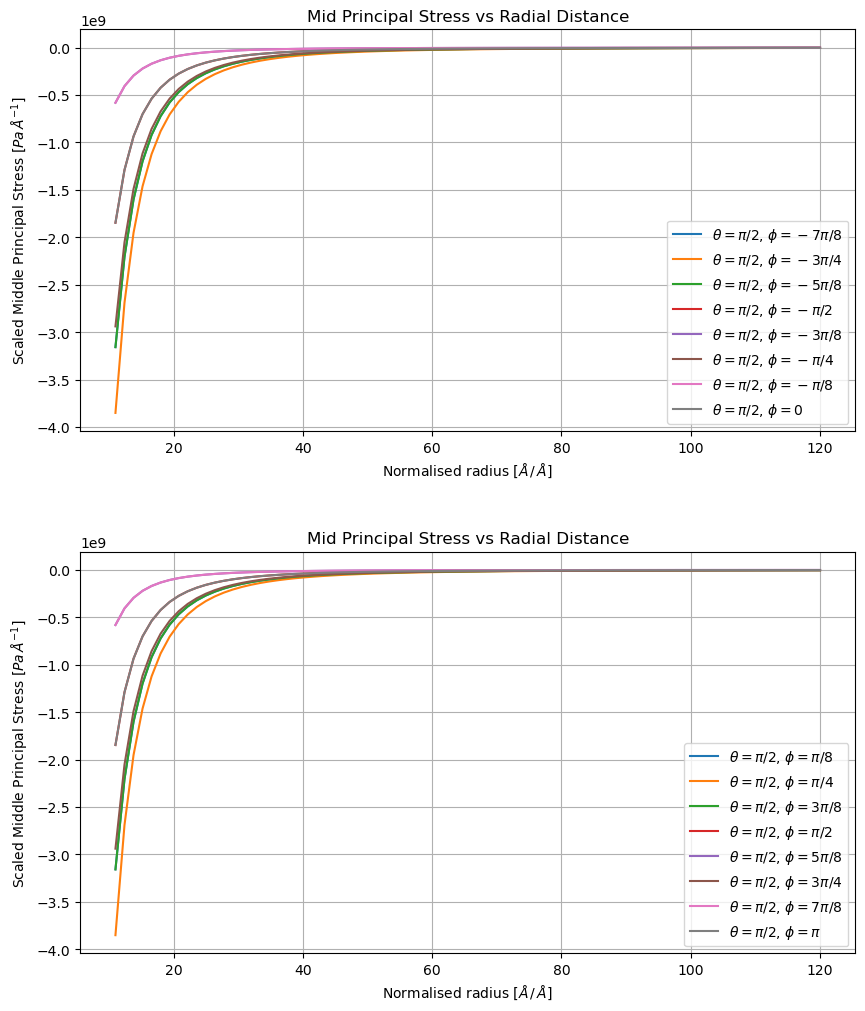

In [241]:
#Mid stress vs radius plot:

fig = PyPlot.figure("Stress vs distance",figsize=(10,12)) # Create a new blank figure
PyPlot.subplot(211);
for j = 1:size(azimuthAngles1)[1]
    labelString = L"$\theta = "*polarLabel*L", $\phi = "*phiLabels1[j];
    PyPlot.plot(radii, midPs1[:, j], label=labelString);
end
PyPlot.title("Mid Principal Stress vs Radial Distance");
PyPlot.xlabel(L"Normalised radius [$\AA \, / \, \AA$]");
PyPlot.ylabel(L"Scaled Middle Principal Stress [$Pa \, \AA^{-1}$]");
PyPlot.grid();
PyPlot.legend();

PyPlot.subplot(212);
for j = 1:size(azimuthAngles2)[1]
    labelString = L"$\theta = "*polarLabel*L", $\phi = "*phiLabels2[j];
    PyPlot.plot(radii, midPs2[:, j], label=labelString);
end
PyPlot.title("Mid Principal Stress vs Radial Distance");
PyPlot.xlabel(L"Normalised radius [$\AA \, / \, \AA$]");
PyPlot.ylabel(L"Scaled Middle Principal Stress [$Pa \, \AA^{-1}$]");
PyPlot.grid();
PyPlot.legend();

PyPlot.subplots_adjust(hspace=0.3);
fig.canvas.draw() # Update the figure
filename = folder*"/"*"stressVdistance3.png";
PyPlot.savefig(filename, dpi=300);

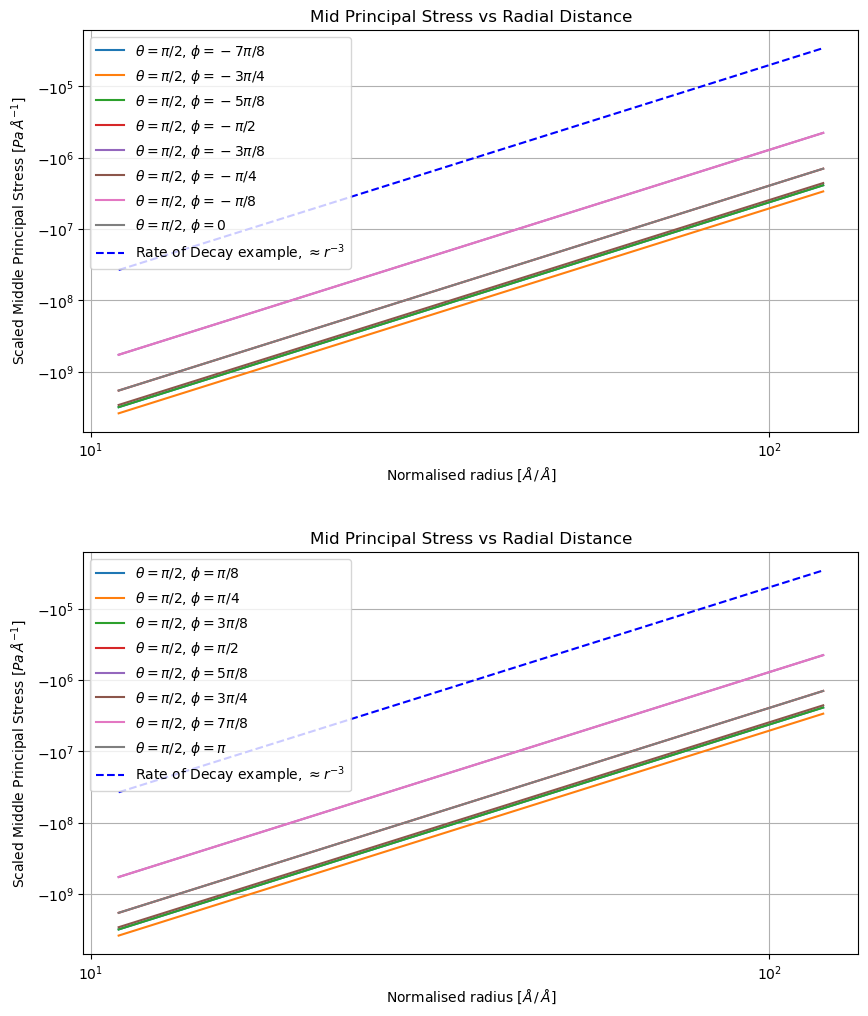

In [242]:
# Log-Log Plot to show rate of decay:
C = 50.0e9;
D = -50.0e9;
decayExamplePlus = [];
decayExampleMinus = [];
decayExamplePlus = [C*r^(-3) for r in radii]
decayExampleMinus = [D*r^(-3) for r in radii]
fig = PyPlot.figure("Stress vs distance",figsize=(10,12)) # Create a new blank figure
PyPlot.subplot(211);
for j = 1:size(azimuthAngles1)[1]
    labelString = L"$\theta = "*polarLabel*L", $\phi = "*phiLabels1[j];
    PyPlot.plot(radii, midPs1[:, j], label=labelString);
end
#PyPlot.plot(radii, decayExamplePlus, "--r", label=L"Rate of Decay example, $\approx r^{-3}$");
PyPlot.plot(radii, decayExampleMinus, "--b", label=L"Rate of Decay example, $\approx r^{-3}$");
PyPlot.title("Mid Principal Stress vs Radial Distance");
PyPlot.xlabel(L"Normalised radius [$\AA \, / \, \AA$]");
PyPlot.ylabel(L"Scaled Middle Principal Stress [$Pa \, \AA^{-1}$]");
PyPlot.yscale("symlog");
PyPlot.xscale("symlog");
PyPlot.grid();
PyPlot.legend();

PyPlot.subplot(212);
for j = 1:size(azimuthAngles2)[1]
    labelString = L"$\theta = "*polarLabel*L", $\phi = "*phiLabels2[j];
    PyPlot.plot(radii, midPs2[:, j], label=labelString);
end
#PyPlot.plot(radii, decayExamplePlus, "--r", label=L"Rate of Decay example, $\approx r^{-3}$");
PyPlot.plot(radii, decayExampleMinus, "--b", label=L"Rate of Decay example, $\approx r^{-3}$");
PyPlot.title("Mid Principal Stress vs Radial Distance");
PyPlot.xlabel(L"Normalised radius [$\AA \, / \, \AA$]");
PyPlot.ylabel(L"Scaled Middle Principal Stress [$Pa \, \AA^{-1}$]");
PyPlot.yscale("symlog");
PyPlot.xscale("symlog");
PyPlot.grid();
PyPlot.legend();

PyPlot.subplots_adjust(hspace=0.3);
fig.canvas.draw() # Update the figure
filename = folder*"/"*"stressVdistance3-log.png";
PyPlot.savefig(filename, dpi=300);

In [243]:
#Generating data for contour plot of stress on a sphere around the dislocation loop:
#--------------------------------------DISTANCE FROM DISLOCATION CENTRE: ----------------------------------------
r = 12*a;
#----------------------------------------------------------------------------------------------------------------
#positions = Array{Float64}(undef, 0, 3);
u = range(0,stop=2*pi,length=360); # Azimuth angle
v = range(0,stop=pi,length=360); # Polar Angle


lu = length(u);
lv = length(v);

x = zeros(lu,lv);
y = zeros(lu,lv);
z = zeros(lu,lv);
maxPsSurfColor = zeros(lu, lv);
minPsSurfColor = zeros(lu, lv);
midPsSurfColor = zeros(lu, lv);
pressureSurfColor = zeros(lu, lv);

for uu=1:lu
	for vv=1:lv
		x[uu,vv]= r*cos(u[uu])*sin(v[vv]);
		y[uu,vv]= r*sin(u[uu])*sin(v[vv]);
		z[uu,vv]= r*cos(v[vv]);
	end
end

for uu=1:lu
   for vv=1:lv
        newStrain = calculate_jacobian(u_disp_green, [x[uu, vv]; y[uu, vv]; z[uu, vv]], C3D, burgers, nu, R, delta_x, 30);
        newStress = hookes_law(newStrain, C3D);
        newMaxP = eigmax(newStress);
        newMinP = eigmin(newStress);
        newMidP = middle_eigenvalue(newStress);
        pressure = (newMaxP + newMinP + newMidP)/3;
        maxPsSurfColor[uu, vv] = newMaxP;
        minPsSurfColor[uu, vv] = newMinP;
        midPsSurfColor[uu, vv] = newMidP;
        pressureSurfColor[uu, vv] = pressure;
    end
end

In [244]:
# Positions for the scatter plot - depreciated:
#circle_x = [];
#circle_y = [];
#circle_z = [];
#extra_r = r;
#for angle in fullAzimuthArr
#    x_pos = extra_r*cos(angle)*sin(polarAngle);
#    y_pos = extra_r*sin(angle)*sin(polarAngle);
#    z_pos = extra_r*cos(polarAngle);
#    circle_x = vcat(circle_x, x_pos);
#    circle_y = vcat(circle_y, y_pos);
#    circle_z = vcat(circle_z, z_pos);
#end

In [245]:
function all_elements_equal(arr)
    if isempty(arr)
        return false  # Array is empty, so elements are not equal
    end
    epsilon = 1.0e-9;
    first_element = arr[1];
    all_equal = true; # Initialise the boolean as true, if any two elements are not the same, this changes to false.
    for j = 1:size(arr)[2], i = 1:size(arr)[1]
        if abs(arr[i, j] - first_element) > 1.0e-9
            all_equal = false;
        end
    end
    
    return all_equal
end

scaledMaxPsColor = zeros(lu, lv);
scaledMinPsColor = zeros(lu, lv);
scaledMidPsColor = zeros(lu, lv);
scaledPresColor = zeros(lu, lv);

max_elements_equal = all_elements_equal(maxPsSurfColor);
if max_elements_equal == true
    scaledMaxPsColor .= maxPsSurfColor / findmax(maxPsSurfColor)[1];
else
    minMaxPsColor =  findmin(maxPsSurfColor)[1];
    scaledMaxPsColor .= maxPsSurfColor .- minMaxPsColor;
    maxMaxPsColor = findmax(scaledMaxPsColor)[1];
    scaledMaxPsColor .= scaledMaxPsColor / maxMaxPsColor;
end

min_elements_equal = all_elements_equal(minPsSurfColor);
if min_elements_equal == true
    scaledMinPsColor .= minPsSurfColor / findmax(minPsSurfColor)[1];
else
    minMinPsColor =  findmin(minPsSurfColor)[1];
    scaledMinPsColor .= minPsSurfColor .- minMinPsColor;
    maxMinPsColor = findmax(scaledMinPsColor)[1];
    scaledMinPsColor .= scaledMinPsColor / maxMinPsColor;
end

mid_elements_equal = all_elements_equal(midPsSurfColor);
if mid_elements_equal == true
    scaledMidPsColor .= midPsSurfColor / findmax(midPsSurfColor)[1];
else 
    minMidPsColor =  findmin(midPsSurfColor)[1];
    scaledMidPsColor .= midPsSurfColor .- minMidPsColor;
    maxMidPsColor = findmax(scaledMidPsColor)[1];
    scaledMidPsColor .= scaledMidPsColor / maxMidPsColor;
end

pres_elements_equal = all_elements_equal(pressureSurfColor);
if pres_elements_equal == true
    scaledPresColor .= pressureSurfColor / findmax(pressureSurfColor)[1];
else 
    minPresColor =  findmin(pressureSurfColor)[1];
    scaledPresColor .= pressureSurfColor .- minPresColor;
    maxPresColor = findmax(scaledPresColor)[1];
    scaledPresColor .= scaledPresColor / maxPresColor;
end


maxColorMap = PyPlot.cm.jet(scaledMaxPsColor);
minColorMap = PyPlot.cm.jet(scaledMinPsColor);
midColorMap = PyPlot.cm.jet(scaledMidPsColor);
presColorMap = PyPlot.cm.jet(scaledPresColor);

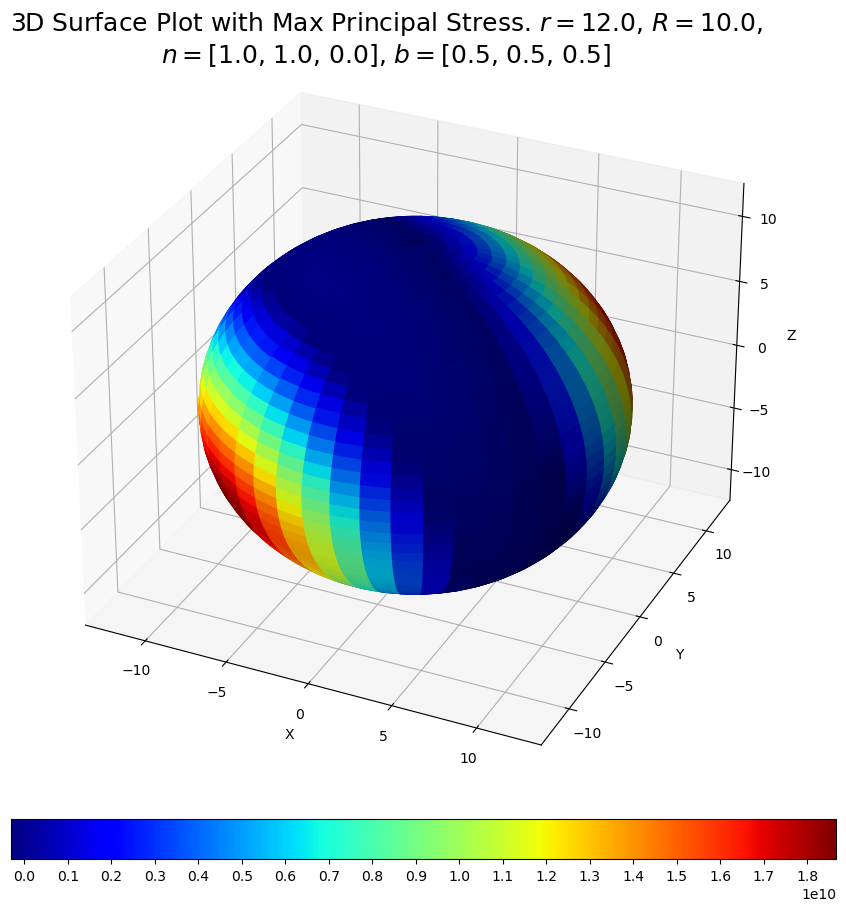

In [246]:
# Create a surface plot with color representing maxPs values
figSphere = PyPlot.figure("Stress surface plots",figsize=(15,10)) # Create a new blank figure
plotTitle = L"3D Surface Plot with Max Principal Stress. $r = $"*string(r)*L", $R = $"*string(R)*",\n"*
            L"$n = $["*string(nu_dir[1])*", "*string(nu_dir[2])*", "*string(nu_dir[3])*"]"*
            L", $b = $["*string(burgers[1])*", "*string(burgers[2])*", "*string(burgers[3])*"]";
# Define the vector components
n1 = nu[1];  # x-component of the vector
n2 = nu[2];  # y-component of the vector
n3 = nu[3];  # z-component of the vector

# Define the starting point of the vector
start_point = [0, 0, 0];

figSphere.suptitle(plotTitle, fontsize=18, x=0.5, y=0.9); #Title for 1 plot
#figSphere.suptitle(plotTitle, fontsize=18, x=0.5, y=0.775); #Title for two plots
PyPlot.subplot(111);
PyPlot.surf(x,y,z,facecolors=maxColorMap);
# Add labels and title
PyPlot.xlabel("X");
PyPlot.ylabel("Y");
PyPlot.zlabel("Z");
PyPlot.view_init(30, -65);

"""
PyPlot.subplot(122);
PyPlot.surf(x,y,z,facecolors=maxColorMap);
# Add labels and title
PyPlot.xlabel("X");
PyPlot.ylabel("Y");
PyPlot.zlabel("Z");
PyPlot.view_init(30, 75);
"""

#Add colorbar
m = PyPlot.cm.ScalarMappable(cmap=PyPlot.cm.jet);
m.set_array(maxPsSurfColor);
cbar_ax = figSphere.add_axes([0.25, 0.05, 0.55, 0.04]) #Axis position for 1 plot
#cbar_ax = figSphere.add_axes([0.225, 0.15, 0.55, 0.03]) # Axis position for two plots
cbar = figSphere.colorbar(m, cax = cbar_ax, fraction=0.046, pad=0.2, orientation="horizontal");
cbar.ax.locator_params(nbins=20);

PyPlot.subplots_adjust(wspace=0.1)
# Save the plot as a PNG:
filename = folder*"/"*"3d_surface_max_r="*string(r)*"a.png";
PyPlot.savefig(filename, dpi=500);

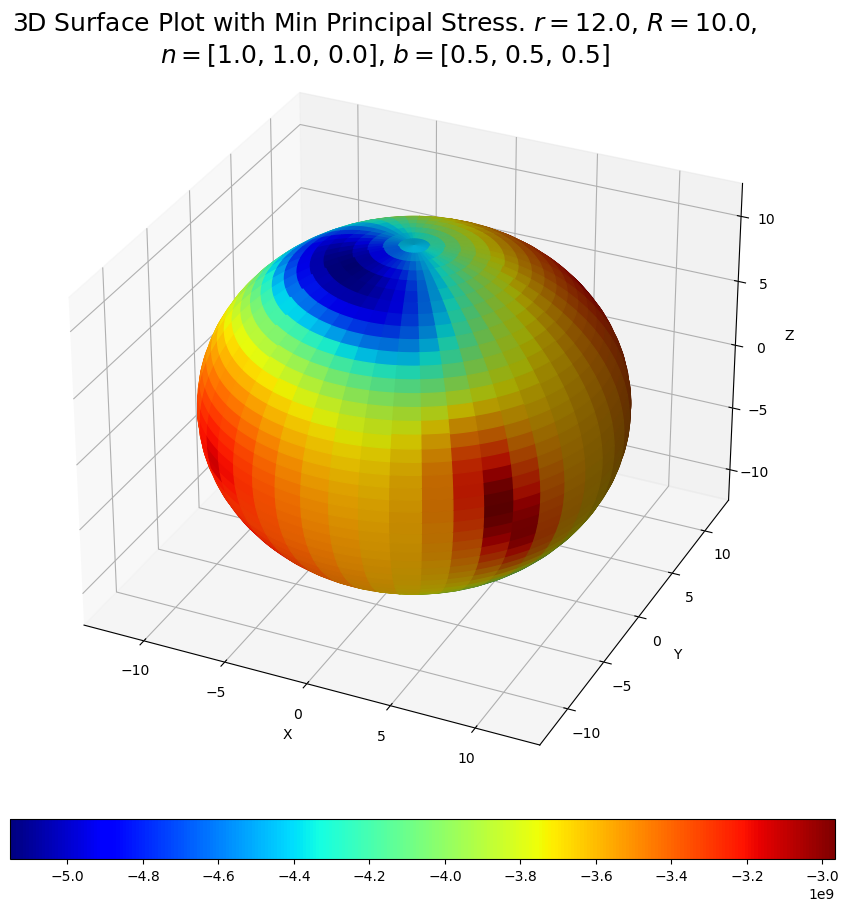

In [247]:
# Create a surface plot with color representing minPs values
figSphere = PyPlot.figure("Stress surface plots",figsize=(15,10)) # Create a new blank figure
plotTitle = L"3D Surface Plot with Min Principal Stress. $r = $"*string(r)*L", $R = $"*string(R)*",\n"*
            L"$n = $["*string(nu_dir[1])*", "*string(nu_dir[2])*", "*string(nu_dir[3])*"]"*
            L", $b = $["*string(burgers[1])*", "*string(burgers[2])*", "*string(burgers[3])*"]";
figSphere.suptitle(plotTitle, fontsize=18, x=0.5, y=0.9); #Title for 1 plot
#figSphere.suptitle(plotTitle, fontsize=18, x=0.5, y=0.775); #Title for two plots
PyPlot.subplot(111);
PyPlot.surf(x,y,z,facecolors=minColorMap);
# Add labels and title
PyPlot.xlabel("X");
PyPlot.ylabel("Y");
PyPlot.zlabel("Z");
PyPlot.view_init(30, -65);

"""
PyPlot.subplot(122);
PyPlot.surf(x,y,z,facecolors=minColorMap);
# Add labels and title
PyPlot.xlabel("X");
PyPlot.ylabel("Y");
PyPlot.zlabel("Z");
PyPlot.view_init(30, 75);
"""

#Add colorbar
m = PyPlot.cm.ScalarMappable(cmap=PyPlot.cm.jet);
m.set_array(minPsSurfColor);
cbar_ax = figSphere.add_axes([0.25, 0.05, 0.55, 0.04]) #Axis position for 1 plot
#cbar_ax = figSphere.add_axes([0.225, 0.15, 0.55, 0.03]) # Axis position for two plots
cbar = figSphere.colorbar(m, cax = cbar_ax, fraction=0.046, pad=0.2, orientation="horizontal");
cbar.ax.locator_params(nbins=20);

PyPlot.subplots_adjust(wspace=0.1)
# Save the plot as a PNG filescaledMidEq
filename = folder*"/"*"3d_surface_min_r="*string(r)*"a.png";
PyPlot.savefig(filename, dpi=500);

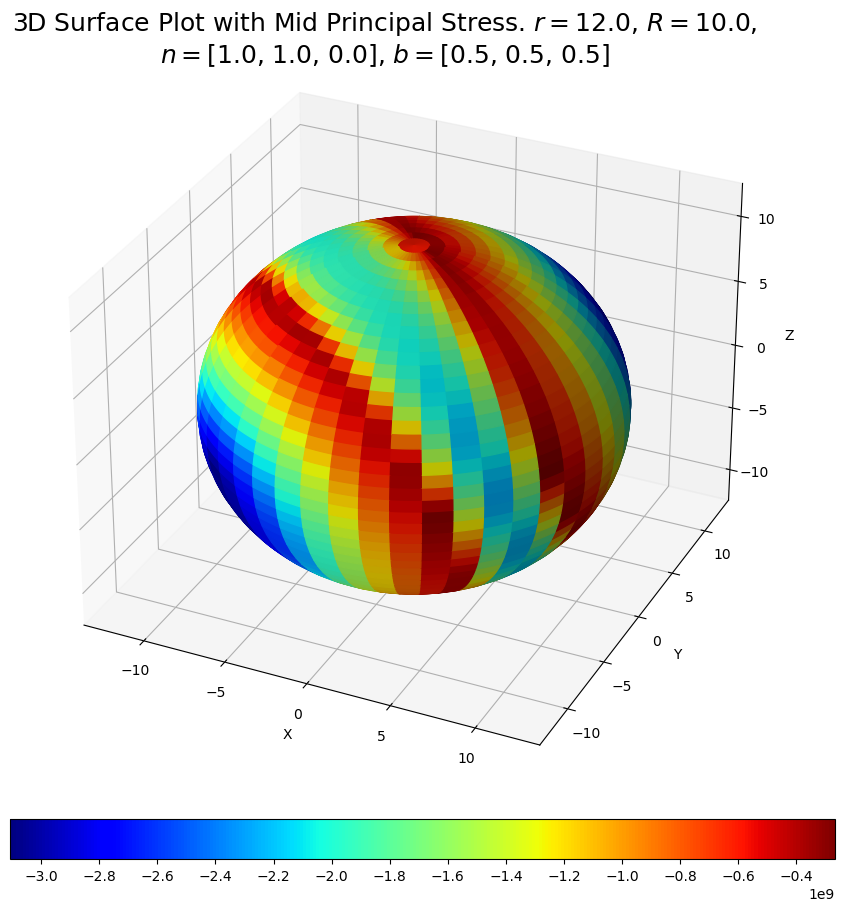

In [248]:
# Create a surface plot with color representing midPs values
figSphere = PyPlot.figure("Stress surface plots",figsize=(15,10)) # Create a new blank figure
plotTitle = L"3D Surface Plot with Mid Principal Stress. $r = $"*string(r)*L", $R = $"*string(R)*",\n"*
            L"$n = $["*string(nu_dir[1])*", "*string(nu_dir[2])*", "*string(nu_dir[3])*"]"*
            L", $b = $["*string(burgers[1])*", "*string(burgers[2])*", "*string(burgers[3])*"]";
figSphere.suptitle(plotTitle, fontsize=18, x=0.5, y=0.9); #Title for 1 plot
#figSphere.suptitle(plotTitle, fontsize=18, x=0.5, y=0.775); #Title for two plots
PyPlot.subplot(111);
PyPlot.surf(x,y,z,facecolors=midColorMap);
# Add labels and title
PyPlot.xlabel("X");
PyPlot.ylabel("Y");
PyPlot.zlabel("Z");
PyPlot.view_init(30, -65);

"""
PyPlot.subplot(122);
PyPlot.surf(x,y,z,facecolors=midColorMap);
# Add labels and title
PyPlot.xlabel("X");
PyPlot.ylabel("Y");
PyPlot.zlabel("Z");
PyPlot.view_init(30, 75);
"""

#Add colorbar
m = PyPlot.cm.ScalarMappable(cmap=PyPlot.cm.jet);
m.set_array(midPsSurfColor);
cbar_ax = figSphere.add_axes([0.25, 0.05, 0.55, 0.04]) #Axis position for 1 plot
#cbar_ax = figSphere.add_axes([0.225, 0.15, 0.55, 0.03]) # Axis position for two plots
cbar = figSphere.colorbar(m, cax = cbar_ax, fraction=0.046, pad=0.2, orientation="horizontal");
cbar.ax.locator_params(nbins=20);

PyPlot.subplots_adjust(wspace=0.1)
# Save the plot as a PNG filescaledMidEq
filename = folder*"/"*"3d_surface_mid_r="*string(r)*"a.png";
PyPlot.savefig(filename, dpi=500);

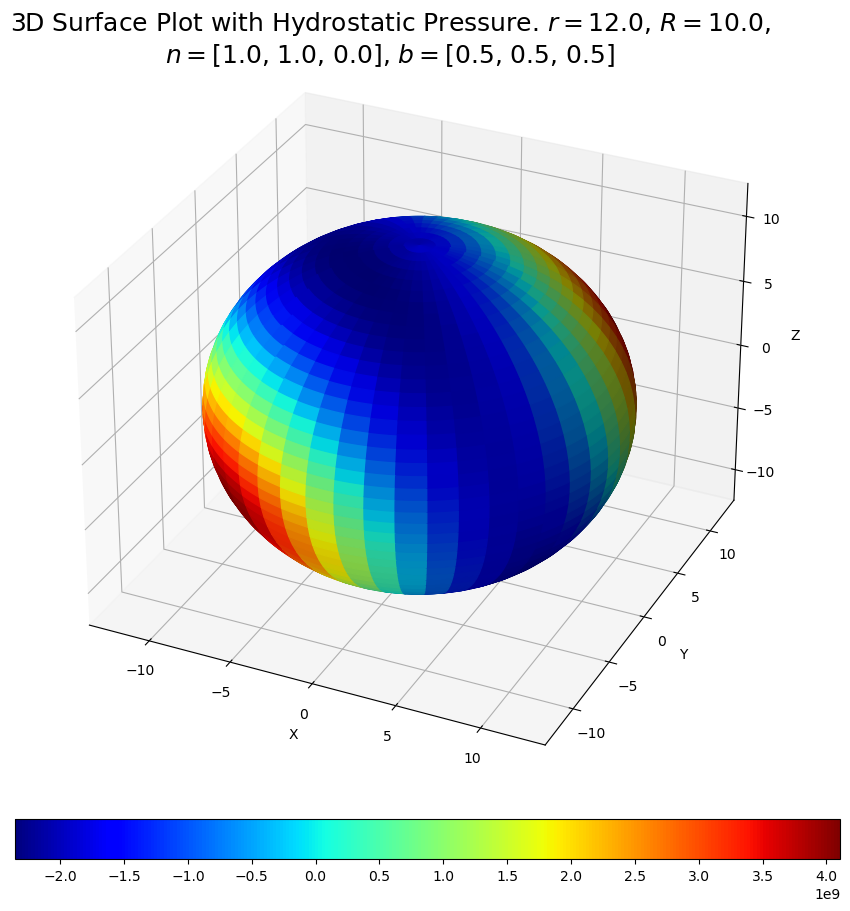

In [249]:
# Create a surface plot with color representing pressure values
figSphere = PyPlot.figure("Stress surface plots",figsize=(15,10)) # Create a new blank figure
plotTitle = L"3D Surface Plot with Hydrostatic Pressure. $r = $"*string(r)*L", $R = $"*string(R)*",\n"*
            L"$n = $["*string(nu_dir[1])*", "*string(nu_dir[2])*", "*string(nu_dir[3])*"]"*
            L", $b = $["*string(burgers[1])*", "*string(burgers[2])*", "*string(burgers[3])*"]";
figSphere.suptitle(plotTitle, fontsize=18, x=0.5, y=0.9); #Title for 1 plot
#figSphere.suptitle(plotTitle, fontsize=18, x=0.5, y=0.775); #Title for two plots
PyPlot.subplot(111);
PyPlot.surf(x,y,z,facecolors=presColorMap);
# Add labels and title
PyPlot.xlabel("X");
PyPlot.ylabel("Y");
PyPlot.zlabel("Z");
PyPlot.view_init(30, -65);

"""
PyPlot.subplot(122);
PyPlot.surf(x,y,z,facecolors=presColorMap);
# Add labels and title
PyPlot.xlabel("X");
PyPlot.ylabel("Y");
PyPlot.zlabel("Z");
PyPlot.view_init(30, 75);
"""

#Add colorbar
m = PyPlot.cm.ScalarMappable(cmap=PyPlot.cm.jet);
m.set_array(pressureSurfColor);
cbar_ax = figSphere.add_axes([0.25, 0.05, 0.55, 0.04]) #Axis position for 1 plot
#cbar_ax = figSphere.add_axes([0.225, 0.15, 0.55, 0.03]) # Axis position for two plots
cbar = figSphere.colorbar(m, cax = cbar_ax, fraction=0.046, pad=0.2, orientation="horizontal");
cbar.ax.locator_params(nbins=20);

PyPlot.subplots_adjust(wspace=0.1)
# Save the plot as a PNG filescaledMidEq
filename = folder*"/"*"3d_surface_pressure_r="*string(r)*"a.png";
PyPlot.savefig(filename, dpi=500);

In [9]:
# Sensitivity Analysis:

# Function to calculate first order sensitivities (using finite differences:)
# Choose Lamé parameters.
μ = 145e9;
poissonRatio = 0.28;
λ = (2*μ*poissonRatio)/(1 - 2*poissonRatio);

function perturb_shear_plus(μ, poissonRatio, eps)
    λ = (2*μ*poissonRatio)/(1 - 2*poissonRatio);
    # Perturb the shear modulus positively:
    μ_p = eps*μ + μ;
    # 3D Voigt elasticities - shear perturbed.
    CVoigt3D_p = [λ+2*μ_p λ       λ       0     0     0;
                  λ       λ+2*μ_p λ       0     0     0;
                  λ       λ       λ+2*μ_p 0     0     0;
                  0       0       0       μ_p   0     0;
                  0       0       0       0     μ_p   0;
                  0       0       0       0     0   μ_p];
    # Convert to full elasticity tensor:
    C3D_p = zeros(3,3,3,3);
    for i=1:3, j=1:3, k=1:3, l=1:3
        C3D_p[i,j,k,l] = CVoigt3D_p[Voigt3D([i j]),Voigt3D([k l])];
    end
    return C3D_p
end


function perturb_shear_minus(μ, poissonRatio, eps)
    λ = (2*μ*poissonRatio)/(1 - 2*poissonRatio);
    # Perturb the shear modulus negatively:
    μ_m = μ - eps*μ;
    # 3D Voigt elasticities - shear perturbed.
    CVoigt3D_m = [λ+2*μ_m λ       λ       0     0     0;
                  λ       λ+2*μ_m λ       0     0     0;
                  λ       λ       λ+2*μ_m 0     0     0;
                  0       0       0       μ_m   0     0;
                  0       0       0       0     μ_m   0; 
                  0       0       0       0     0   μ_m];
    # Convert to full elasticity tensor:
    C3D_m = zeros(3,3,3,3);
    for i=1:3, j=1:3, k=1:3, l=1:3
        C3D_m[i,j,k,l] = CVoigt3D_m[Voigt3D([i j]),Voigt3D([k l])];
    end
    return C3D_m
end

function perturb_lamme_plus(μ, poissonRatio, eps)
    λ = (2*μ*poissonRatio)/(1 - 2*poissonRatio);
    # Perturb the lamme parameter positively:
    λ_p = eps*λ + λ;
    # 3D Voigt elasticities - shear perturbed.
    CVoigt3D_p = [λ_p+2*μ λ_p     λ_p     0     0     0;
                  λ_p     λ_p+2*μ λ_p     0     0     0;
                  λ_p     λ_p     λ_p+2*μ 0     0     0;
                  0       0       0       μ     0     0;
                  0       0       0       0     μ     0;
                  0       0       0       0     0     μ];
    # Convert to full elasticity tensor:
    C3D_p = zeros(3,3,3,3);
    for i=1:3, j=1:3, k=1:3, l=1:3
        C3D_p[i,j,k,l] = CVoigt3D_p[Voigt3D([i j]),Voigt3D([k l])];
    end
    return C3D_p
end

function perturb_lamme_minus(μ, poissonRatio, eps)
    λ = (2*μ*poissonRatio)/(1 - 2*poissonRatio);
    # Perturb the lamme parameter positively:
    λ_m = λ - eps*λ;
    # 3D Voigt elasticities - shear perturbed.
    CVoigt3D_m = [λ_m+2*μ λ_m     λ_m     0     0     0;
                  λ_m     λ_m+2*μ λ_m     0     0     0;
                  λ_m     λ_m     λ_m+2*μ 0     0     0;
                  0       0       0       μ     0     0;
                  0       0       0       0     μ     0;
                  0       0       0       0     0     μ];
    # Convert to full elasticity tensor:
    C3D_m = zeros(3,3,3,3);
    for i=1:3, j=1:3, k=1:3, l=1:3
        C3D_m[i,j,k,l] = CVoigt3D_m[Voigt3D([i j]),Voigt3D([k l])];
    end
    return C3D_p
end

function first_order_sensitivity(principal_p, principal_m, eps_modulus)
    sensitivity1 = (principal_p - principal_m)/(2*eps_modulus);
    return sensitivity1
end

function second_order_sensitivity(principal_p, principal_m, principal_0, eps_modulus)
    sensitivity2 = (principal_p - 2*principal_0 + principal_m)/(eps_modulus^2);
    return sensitivity2
end

function first_order_sensitivity_vec(principal_p, principal_m, eps_modulus)
    sensitivity1 = (principal_p - principal_m)/(2*norm(eps_modulus));
    return sensitivity1
end

function second_order_sensitivity_vec(principal_p, principal_m, principal_0, eps_modulus)
    sensitivity2 = (principal_p - 2*principal_0 + principal_m)/(norm(eps_modulus)^2);
    return sensitivity2
end
# Lattice spacing:
a = 3.18e-10;
#Non-dimensionalising:
a = a/a;
# Dislocation radius:
R = 10*a;

# Prismatic dislocation:
burgers = 1/2 * [1.0; 1.0; 1.0] * a;
nu_1 = [1.0, 1.0, 0.0];
#Normal unit vector:
nu = nu_1 / norm(nu_1);
# Fixed position:
x = [1*a; 1*a; 20*a];

delta_x = 1e-6;

μ_0 = 145.0e9;
poissonRatio_0 = 0.28;
λ_0 = (2*μ_0*poissonRatio_0)/(1 - 2*poissonRatio_0);

# First order and second order sensitivities in shear modulus:
C3D_p, C3D_m = zeros(3,3,3,3);
C3D_p = perturb_shear_plus(μ_0, poissonRatio_0, 1e-6);
C3D_m = perturb_shear_minus(μ_0, poissonRatio_0, 1e-6);
CVoigt3D_0 = [λ_0+2*μ_0  λ_0        λ_0        0     0     0;
              λ_0        λ_0+2*μ_0  λ_0        0     0     0;
              λ_0        λ_0        λ_0+2*μ_0  0     0     0;
              0          0          0          μ_0   0     0;
              0          0          0          0     μ_0   0;
              0          0          0          0     0     μ_0];
# Convert to full elasticity tensor.
C3D_0 = zeros(3,3,3,3);
for i=1:3, j=1:3, k=1:3, l=1:3
    C3D_0[i,j,k,l] = CVoigt3D_0[Voigt3D([i j]),Voigt3D([k l])];
end
u_shear_p, u_shear_m, u_shear_0 = zeros(Float64, 3);
u_shear_p = u_disp_green(x, C3D_p, burgers, nu, R, 30);
u_shear_m = u_disp_green(x, C3D_m, burgers, nu, R, 30);
u_shear_0 = u_disp_green(x, C3D_0, burgers, nu, R, 30);
strain_p = calculate_jacobian(u_disp_green, x, C3D_p, burgers, nu, R, delta_x, 30);
strain_m = calculate_jacobian(u_disp_green, x, C3D_m, burgers, nu, R, delta_x, 30);
strain_0 = calculate_jacobian(u_disp_green, x, C3D_0, burgers, nu, R, delta_x, 30);
stress_p = hookes_law(strain_p, C3D_p);
stress_m = hookes_law(strain_m, C3D_m);
stress_0 = hookes_law(strain_0, C3D_0);
maxP_p = eigmax(stress_p);
maxP_m = eigmax(stress_m);
maxP_0 = eigmax(stress_0);
minP_p = eigmin(stress_p);
minP_m = eigmin(stress_m);
minP_0 = eigmin(stress_0);

maxP_sensitivity1_shear = μ_0*first_order_sensitivity(maxP_p, maxP_m, 1e-6*μ_0);
maxP_sensitivity2_shear =  μ_0^2*second_order_sensitivity(maxP_p, maxP_m, maxP_0, 1e-6*μ_0);

print("epsilon shear: ", 1e-6*μ_0, "\n");

print("1st order Sensitivity for shear: ", maxP_sensitivity1_shear, "\n");
print("2nd order Sensitivity for shear: ", maxP_sensitivity2_shear, "\n");

# First order and second order sensitivities in lamme param:
C3D_p, C3D_m = zeros(3,3,3,3);
C3D_p = perturb_lamme_plus(μ_0, poissonRatio_0, 1e-6);
C3D_m = perturb_lamme_minus(μ_0, poissonRatio_0, 1e-6);
CVoigt3D_0 = [λ_0+2*μ_0  λ_0        λ_0        0     0     0;
              λ_0        λ_0+2*μ_0  λ_0        0     0     0;
              λ_0        λ_0        λ_0+2*μ_0  0     0     0;
              0          0          0          μ_0   0     0;
              0          0          0          0     μ_0   0;
              0          0          0          0     0     μ_0];
# Convert to full elasticity tensor.
C3D_0 = zeros(3,3,3,3);
for i=1:3, j=1:3, k=1:3, l=1:3
    C3D_0[i,j,k,l] = CVoigt3D_0[Voigt3D([i j]),Voigt3D([k l])];
end
u_shear_p, u_shear_m, u_shear_0 = zeros(Float64, 3);
u_shear_p = u_disp_green(x, C3D_p, burgers, nu, R, 30);
u_shear_m = u_disp_green(x, C3D_m, burgers, nu, R, 30);
u_shear_0 = u_disp_green(x, C3D_0, burgers, nu, R, 30);
strain_p = calculate_jacobian(u_disp_green, x, C3D_p, burgers, nu, R, delta_x, 30);
strain_m = calculate_jacobian(u_disp_green, x, C3D_m, burgers, nu, R, delta_x, 30);
strain_0 = calculate_jacobian(u_disp_green, x, C3D_0, burgers, nu, R, delta_x, 30);
stress_p = hookes_law(strain_p, C3D_p);
stress_m = hookes_law(strain_m, C3D_m);
stress_0 = hookes_law(strain_0, C3D_0);
maxP_p = eigmax(stress_p);
maxP_m = eigmax(stress_m);
maxP_0 = eigmax(stress_0);
minP_p = eigmin(stress_p);
minP_m = eigmin(stress_m);
minP_0 = eigmin(stress_0);

maxP_sensitivity1_lamme = λ_0*first_order_sensitivity(maxP_p, maxP_m, 1e-6*λ_0);
maxP_sensitivity2_lamme = λ_0^2*second_order_sensitivity(maxP_p, maxP_m, maxP_0, 1e-6*λ_0);

print("epsilon lamme: ", 1e-6*λ_0, "\n");

print("1st order Sensitivity for lamme: ", maxP_sensitivity1_lamme, "\n");
print("2nd order Sensitivity for lamme: ", maxP_sensitivity2_lamme, "\n");


# First order and second order sensitivities in the burgers vector:
burgersEps = burgers*1.0e-6;
burgersPlus = burgers + burgersEps;
burgersMinus = burgers - burgersEps;
CVoigt3D_0 = [λ_0+2*μ_0  λ_0        λ_0        0     0     0;
              λ_0        λ_0+2*μ_0  λ_0        0     0     0;
              λ_0        λ_0        λ_0+2*μ_0  0     0     0;
              0          0          0          μ_0   0     0;
              0          0          0          0     μ_0   0;
              0          0          0          0     0     μ_0];
# Convert to full elasticity tensor.
C3D_0 = zeros(3,3,3,3);
for i=1:3, j=1:3, k=1:3, l=1:3
    C3D_0[i,j,k,l] = CVoigt3D_0[Voigt3D([i j]),Voigt3D([k l])];
end
u_shear_p, u_shear_m, u_shear_0 = zeros(Float64, 3);
u_shear_p = u_disp_green(x, C3D_0, burgersPlus, nu, R, 30);
u_shear_m = u_disp_green(x, C3D_0, burgersMinus, nu, R, 30);
u_shear_0 = u_disp_green(x, C3D_0, burgers, nu, R, 30);
strain_p = calculate_jacobian(u_disp_green, x, C3D_0, burgersPlus, nu, R, delta_x, 30);
strain_m = calculate_jacobian(u_disp_green, x, C3D_0, burgersMinus, nu, R, delta_x, 30);
strain_0 = calculate_jacobian(u_disp_green, x, C3D_0, burgers, nu, R, delta_x, 30);
stress_p = hookes_law(strain_p, C3D_0);
stress_m = hookes_law(strain_m, C3D_0);
stress_0 = hookes_law(strain_0, C3D_0);
maxP_p = eigmax(stress_p);
maxP_m = eigmax(stress_m);
maxP_0 = eigmax(stress_0);
minP_p = eigmin(stress_p);
minP_m = eigmin(stress_m);
minP_0 = eigmin(stress_0);

maxP_sensitivity1_burg = norm(burgers)*first_order_sensitivity_vec(maxP_p, maxP_m, burgersEps);
maxP_sensitivity2_burg = norm(burgers)^2*second_order_sensitivity_vec(maxP_p, maxP_m, maxP_0, burgersEps);

print("epsilon burg: ", norm(burgersEps), "\n");

print("1st order Sensitivity for burger's vector: ", maxP_sensitivity1_burg, "\n");
print("2nd order Sensitivity for burger's vector: ", maxP_sensitivity2_burg, "\n");


# First order and second order sensitivities in the loop radius R:
R_eps = R*1.0e-6;
R_p = R + R_eps;
R_m = R - R_eps;
CVoigt3D_0 = [λ_0+2*μ_0  λ_0        λ_0        0     0     0;
              λ_0        λ_0+2*μ_0  λ_0        0     0     0;
              λ_0        λ_0        λ_0+2*μ_0  0     0     0;
              0          0          0          μ_0   0     0;
              0          0          0          0     μ_0   0;
              0          0          0          0     0     μ_0];
# Convert to full elasticity tensor.
C3D_0 = zeros(3,3,3,3);
for i=1:3, j=1:3, k=1:3, l=1:3
    C3D_0[i,j,k,l] = CVoigt3D_0[Voigt3D([i j]),Voigt3D([k l])];
end
u_shear_p, u_shear_m, u_shear_0 = zeros(Float64, 3);
u_shear_p = u_disp_green(x, C3D_0, burgers, nu, R_p, 30);
u_shear_m = u_disp_green(x, C3D_0, burgers, nu, R_m, 30);
u_shear_0 = u_disp_green(x, C3D_0, burgers, nu, R, 30);
strain_p = calculate_jacobian(u_disp_green, x, C3D_0, burgers, nu, R_p, delta_x, 30);
strain_m = calculate_jacobian(u_disp_green, x, C3D_0, burgers, nu, R_m, delta_x, 30);
strain_0 = calculate_jacobian(u_disp_green, x, C3D_0, burgers, nu, R, delta_x, 30);
stress_p = hookes_law(strain_p, C3D_0);
stress_m = hookes_law(strain_m, C3D_0);
stress_0 = hookes_law(strain_0, C3D_0);
maxP_p = eigmax(stress_p);
maxP_m = eigmax(stress_m);
maxP_0 = eigmax(stress_0);
minP_p = eigmin(stress_p);
minP_m = eigmin(stress_m);
minP_0 = eigmin(stress_0);

maxP_sensitivity1_R = R*first_order_sensitivity(maxP_p, maxP_m, R_eps);
maxP_sensitivity2_R = R^2*second_order_sensitivity(maxP_p, maxP_m, maxP_0, R_eps);

print("epsilon R: ", R_eps, "\n");

print("1st order Sensitivity for the loop radius: ", maxP_sensitivity1_R, "\n");
print("2nd order Sensitivity for the loop radius: ", maxP_sensitivity2_R, "\n");

epsilon shear: 145000.0
1st order Sensitivity for shear: -5.956885847821832e7
2nd order Sensitivity for shear: 1.3922014452517035e13
epsilon lamme: 184545.4545454546
1st order Sensitivity for lamme: 0.0
2nd order Sensitivity for lamme: 2.4418136987090112e14
epsilon burg: 8.660254037844387e-7
1st order Sensitivity for burger's vector: 4.981673050671815e7
2nd order Sensitivity for burger's vector: 1.0646185755729674e13
epsilon R: 9.999999999999999e-6
1st order Sensitivity for the loop radius: 9.17867921255529e7
2nd order Sensitivity for the loop radius: 1.3603268183767797e13


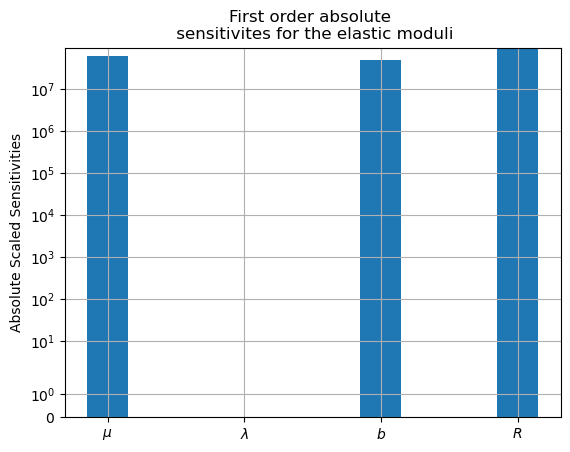

In [10]:
# Plot first order sensitivities::
params = [L"\mu", L"\lambda", L"$b$", L"$R$"];
sens1 = [abs(maxP_sensitivity1_shear), abs(maxP_sensitivity1_lamme), abs(maxP_sensitivity1_burg), abs(maxP_sensitivity1_R)];
PyPlot.bar(params, sens1, width = 0.3);
PyPlot.ylabel("Absolute Scaled Sensitivities");
PyPlot.yscale("symlog");
PyPlot.title("First order absolute \n sensitivites for the elastic moduli");
PyPlot.grid();
PyPlot.savefig("firstOrderSensitivities.png", dpi=500);

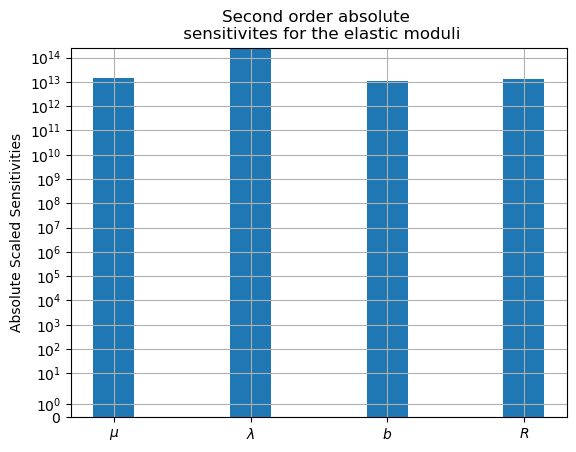

In [11]:
# Second order:
sens2 = [abs(maxP_sensitivity2_shear), abs(maxP_sensitivity2_lamme), abs(maxP_sensitivity2_burg), abs(maxP_sensitivity2_R)];
PyPlot.bar(params, sens2, width=0.3);
PyPlot.ylabel("Absolute Scaled Sensitivities");
PyPlot.yscale("symlog");
PyPlot.title("Second order absolute \n sensitivites for the elastic moduli");
PyPlot.grid();
PyPlot.savefig("secondOrderSensitivities.png", dpi=500);

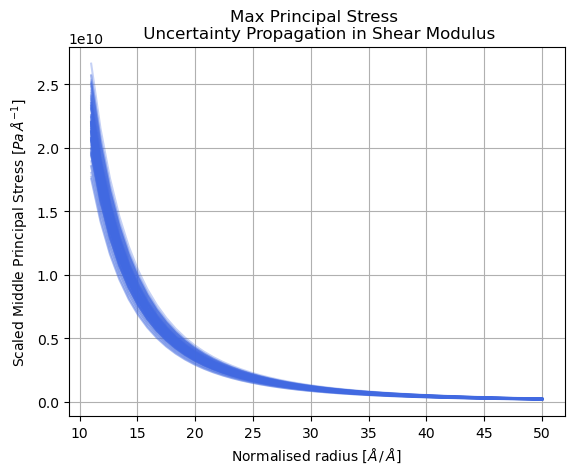

In [267]:
#Uncertainty Propagation:
#-----------------------------------------Orientation: -------------------------------------------------------
phu = pi/4;
theta = pi/2;
#-------------------------------------------------------------------------------------------------------------

# Lattice spacing:
a = 3.18e-10;
#Non-dimensionalising:
a = a/a;
# Dislocation radius:
R = 10*a;
#-----------------------------------------Radii array: -------------------------------------------------------
radii = range(11*a, 50*a, length=49);
#-------------------------------------------------------------------------------------------------------------

# Prismatic dislocation:
burgers = 1/2 * [1.0; 1.0; 1.0] * a;
nu_1 = [1.0, 1.0, 0.0];
#Normal unit vector:
nu = nu_1 / norm(nu_1);
delta_x = 1e-6;

# Setting up elastic moduli distributions:
seed = Random.seed!(1000);
shearModDist = Normal(145e9, 15e9);
lammeMean = (2*145e9*0.28)/(1 - 2*0.28);
lammeStd = (2*15e9*0.01)/(1 - 2*0.01);
lammeParamDist = Normal(lammeMean, lammeStd);

# Sampling elastic moduli:
shearMods = rand(shearModDist, 100);
lammeParams = rand(lammeParamDist, 100);

# Will plot for a specific orientation:
# Propagating uncertainty in shear modulus:
for i in range(1,100, step=1)
    μ = shearMods[i];
    λ = lammeMean;
    #λ = lammeParams[i];
    maxPrincipals = Array{Float64,1}(undef, size(radii)[1]);
    j = 1;
    for r in radii
       pos = [r*sin(theta)*cos(phi); r*sin(theta)*sin(phi); r*cos(theta)]; 
        CVoigt3D = [λ+2*μ  λ      λ      0   0   0;
                    λ      λ+2*μ  λ      0   0   0;
                    λ      λ      λ+2*μ  0   0   0;
                    0      0      0      μ   0   0;
                    0      0      0      0   μ   0;
                    0      0      0      0   0   μ];
        # Convert to full elasticity tensor.
        C3D = zeros(3,3,3,3);
        for i=1:3, j=1:3, k=1:3, l=1:3
            C3D[i,j,k,l] = CVoigt3D[Voigt3D([i j]),Voigt3D([k l])];
        end
       strain = calculate_jacobian(u_disp_green, pos, C3D, burgers, nu, R, delta_x, 30);
       stress = hookes_law(strain, C3D);
       maxP = eigmax(stress);
       maxPrincipals[j] = maxP; 
       j = j + 1;
    end
    PyPlot.plot(radii, maxPrincipals, "-", color="royalblue", alpha=0.3);
end
PyPlot.title("Max Principal Stress \n Uncertainty Propagation in Shear Modulus");
PyPlot.xlabel(L"Normalised radius [$\AA \, / \, \AA$]");
PyPlot.ylabel(L"Scaled Middle Principal Stress [$Pa \, \AA^{-1}$]");
PyPlot.grid();
PyPlot.savefig("unceratintyPropShear.png", dpi=300);



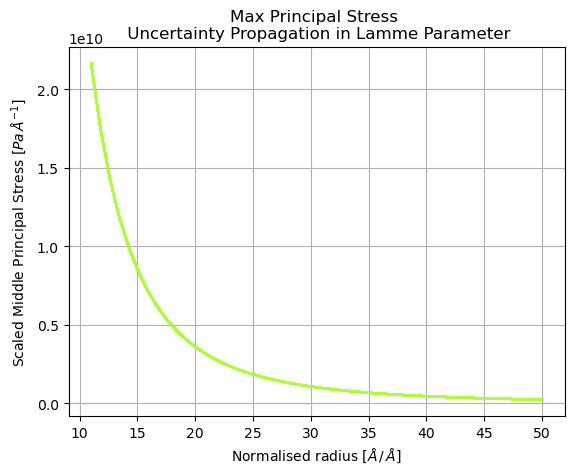

In [268]:
# Propagating uncertainty in lamme parameter:
for i in range(1,100, step=1)
    μ = 145e9;
    λ = lammeParams[i];
    maxPrincipals = Array{Float64,1}(undef, size(radii)[1]);
    j = 1;
    for r in radii
       pos = [r*sin(theta)*cos(phi); r*sin(theta)*sin(phi); r*cos(theta)]; 
        CVoigt3D = [λ+2*μ  λ      λ      0   0   0;
                    λ      λ+2*μ  λ      0   0   0;
                    λ      λ      λ+2*μ  0   0   0;
                    0      0      0      μ   0   0;
                    0      0      0      0   μ   0;
                    0      0      0      0   0   μ];
        # Convert to full elasticity tensor.
        C3D = zeros(3,3,3,3);
        for i=1:3, j=1:3, k=1:3, l=1:3
            C3D[i,j,k,l] = CVoigt3D[Voigt3D([i j]),Voigt3D([k l])];
        end
       strain = calculate_jacobian(u_disp_green, pos, C3D, burgers, nu, R, delta_x, 30);
       stress = hookes_law(strain, C3D);
       maxP = eigmax(stress);
       maxPrincipals[j] = maxP; 
       j = j + 1;
    end
    PyPlot.plot(radii, maxPrincipals, "-", color="greenyellow", alpha=0.3);
end
PyPlot.title("Max Principal Stress \n Uncertainty Propagation in Lamme Parameter");
PyPlot.xlabel(L"Normalised radius [$\AA \, / \, \AA$]");
PyPlot.ylabel(L"Scaled Middle Principal Stress [$Pa \, \AA^{-1}$]");
PyPlot.grid();
PyPlot.savefig("unceratintyPropLamme.png", dpi=300);

In [ ]:
# Will now try cubic symmetry now:
# Define elastic compliance tensors first.
# Elasticity coefficients, trying values from Pui-Wai Ma, D. R. Mason and S. Duradev:
C11 = 520e11; C44 = 160e11; C12 = 200e11;
# 3D Voigt elasticities.
CVoigt3D = [C11   C12   C12   0    0    0;
            C12   C11   C12   0    0    0;
            C12   C12   C11   0    0    0;
            0     0     0     C44  0    0;
            0     0     0     0    C44  0;
            0     0     0     0    0    C44];
# 2D Voigt elasticities.
C33 = C44;
CVoigt2D = [C11   C12   0;
            C12   C11   0;
            0     0     C33];

# Convert to full elasticity tensors.
C3D = zeros(3,3,3,3);
for i=1:3, j=1:3, k=1:3, l=1:3
    C3D[i,j,k,l] = CVoigt3D[Voigt3D([i j]),Voigt3D([k l])];
end

C2D = zeros(2,2,2,2);
for i=1:2, j=1:2, k=1:2, l=1:2
    C2D[i,j,k,l] = CVoigt2D[Voigt2D([i j]),Voigt2D([k l])];
end

